In [1]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')

In [2]:
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')

symbols_list = sp500['Symbol'].unique().tolist()

end_date = '2023-09-27'

start_date = pd.to_datetime(end_date)-pd.DateOffset(365*8)

df = yf.download(tickers=symbols_list,
                 start=start_date,
                 end=end_date).stack()

df.index.names = ['date', 'ticker']

df.columns = df.columns.str.lower()

df

[*********************100%%**********************]  503 of 503 completed

3 Failed downloads:
['VLTO', 'GEV', 'SOLV']: YFChartError("%ticker%: Data doesn't exist for startDate = 1443499200, endDate = 1695787200")


Price               adj close       close        high         low        open  \
date       ticker                                                               
2015-09-29 A        31.483561   33.740002   34.060001   33.240002   33.360001   
           AAL      37.361618   39.180000   39.770000   38.790001   39.049999   
           AAPL     24.651136   27.264999   28.377501   26.965000   28.207500   
           ABBV     36.334908   52.790001   54.189999   51.880001   53.099998   
           ABT      33.478703   39.500000   40.150002   39.029999   39.259998   
...                       ...         ...         ...         ...         ...   
2023-09-26 XYL      88.736298   89.519997   90.849998   89.500000   90.379997   
           YUM     122.211014  124.010002  124.739998  123.449997  124.239998   
           ZBH     111.534813  112.459999  117.110001  112.419998  116.769997   
           ZBRA    223.960007  223.960007  226.649994  222.580002  225.970001   
           ZTS     175.547699  176.869995  178.449997  176.270004  176.580002   

Price                   volume  
date       ticker               
2015-09-29 A         2252400.0  
           AAL       7478800.0  
           AAPL    293461600.0  
           ABBV     12842800.0  
           ABT      12287500.0  
...                        ...  
2023-09-26 XYL       1322400.0  
           YUM       1500600.0  
           ZBH       3610500.0  
           ZBRA       355400.0  
           ZTS       1463200.0  

[987967 rows x 6 columns]

In [3]:
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
                                                          
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])
                                                          
df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                        low=stock_data['low'],
                        close=stock_data['close'],
                        length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

df['dollar_volume'] = (df['adj close']*df['volume'])/1e6

df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2015-09-29 A        31.483561   33.740002   34.060001   33.240002   33.360001   
           AAL      37.361618   39.180000   39.770000   38.790001   39.049999   
           AAPL     24.651136   27.264999   28.377501   26.965000   28.207500   
           ABBV     36.334908   52.790001   54.189999   51.880001   53.099998   
           ABT      33.478703   39.500000   40.150002   39.029999   39.259998   
...                       ...         ...         ...         ...         ...   
2023-09-26 XYL      88.736298   89.519997   90.849998   89.500000   90.379997   
           YUM     122.211014  124.010002  124.739998  123.449997  124.239998   
           ZBH     111.534813  112.459999  117.110001  112.419998  116.769997   
           ZBRA    223.960007  223.960007  226.649994  222.580002  225.970001   
           ZTS     175.547699  176.869995  178.449997  176.270004  176.580002   

Price                   volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2015-09-29 A         2252400.0         -0.000998        NaN       NaN   
           AAL       7478800.0         -0.000443        NaN       NaN   
           AAPL    293461600.0         -0.005712        NaN       NaN   
           ABBV     12842800.0         -0.054655        NaN       NaN   
           ABT      12287500.0         -0.009402        NaN       NaN   
...                        ...               ...        ...       ...   
2023-09-26 XYL       1322400.0         -0.000018  26.146746  4.485761   
           YUM       1500600.0         -0.000051  36.057165  4.811707   
           ZBH       3610500.0          0.000022  31.893256  4.745884   
           ZBRA       355400.0          0.000133  29.494977  5.400991   
           ZTS       1463200.0          0.000062  42.623467  5.156108   

Price                bb_mid   bb_high       atr      macd  dollar_volume  
date       ticker                                                         
2015-09-29 A            NaN       NaN       NaN       NaN      70.913572  
           AAL          NaN       NaN       NaN       NaN     279.420069  
           AAPL         NaN       NaN       NaN       NaN    7234.161929  
           ABBV         NaN       NaN       NaN       NaN     466.641950  
           ABT          NaN       NaN       NaN       NaN     411.369558  
...                     ...       ...       ...       ...            ...  
2023-09-26 XYL     4.567684  4.649607  0.033800 -2.159189     117.344880  
           YUM     4.841672  4.871637  0.142547 -1.363695     183.389847  
           ZBH     4.785551  4.825217 -0.381708 -0.881067     402.696442  
           ZBRA    5.539167  5.677342 -0.057389 -1.600791      79.595386  
           ZTS     5.214922  5.273735  0.651515 -1.188279     256.861393  

[987967 rows x 14 columns]

In [4]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open',
                                                          'high', 'low', 'close']]

data = (pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
                   df.unstack()[last_cols].resample('M').last().stack('ticker')],
                  axis=1)).dropna()

data

dollar_volume   adj close  garman_klass_vol        rsi  \
date       ticker                                                           
2015-11-30 A          135.992824   39.023193         -0.001992  73.421656   
           AAL        287.915800   39.429932         -0.000966  40.718984   
           AAPL      4023.983814   26.854132         -0.003307  55.537306   
           ABBV       337.563913   40.393532         -0.059549  49.376874   
           ABT        211.659053   38.293579         -0.011216  56.962688   
...                          ...         ...               ...        ...   
2023-09-30 OTIS       154.361752   78.356506         -0.000097  33.116253   
           ABNB      1633.500725  132.279999          0.000213  44.494127   
           CEG        196.670368  107.862022          0.000131  55.245464   
           GEHC       212.275851   66.130211          0.000185  40.922312   
           KVUE       670.804278   20.006195         -0.000159  35.706355   

                     bb_low    bb_mid   bb_high       atr      macd  
date       ticker                                                    
2015-11-30 A       3.545991  3.618440  3.690888 -1.033887  0.567158  
           AAL     3.672028  3.749832  3.827636  0.190822 -0.418772  
           AAPL    3.281679  3.324990  3.368302 -0.967900 -0.142790  
           ABBV    3.726695  3.774943  3.823191 -0.526809  0.145677  
           ABT     3.656056  3.677909  3.699763 -1.064842  0.335558  
...                     ...       ...       ...       ...       ...  
2023-09-30 OTIS    4.370137  4.415425  4.460712 -1.028320 -1.534535  
           ABNB    4.857047  4.940924  5.024801 -1.006939 -0.037854  
           CEG     4.652147  4.692320  4.732493 -0.436215  0.366876  
           GEHC    4.155436  4.212972  4.270508 -0.893478 -1.116463  
           KVUE    3.014275  3.089221  3.164168 -0.899746 -1.435620  

[46648 rows x 9 columns]

In [5]:
data['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())

data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))

data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2016-10-31 AAL      39.134331         -0.000176  62.203547  3.604673   
           AAPL     26.212471         -0.002468  49.891040  3.294237   
           ABBV     40.245125         -0.046691  27.477755  3.753446   
           ABT      34.293453         -0.007492  38.008829  3.554632   
           ACN     103.569618         -0.004643  53.823685  4.637342   
...                       ...               ...        ...       ...   
2023-09-30 XOM     113.372101         -0.000065  59.440187  4.687091   
           MRNA     98.120003          0.000146  38.747314  4.582514   
           UBER     44.270000          0.000441  45.005268  3.806654   
           CRWD    160.479996          0.000144  51.534803  5.026187   
           ABNB    132.279999          0.000213  44.494127  4.857047   

                     bb_mid   bb_high       atr      macd  
date       ticker                                          
2016-10-31 AAL     3.655493  3.706314  0.402199  1.131596  
           AAPL    3.323117  3.351997 -1.038688 -0.195978  
           ABBV    3.807610  3.861774 -0.893132 -0.760594  
           ABT     3.605106  3.655580 -1.035224 -0.650888  
           ACN     4.648980  4.660617 -0.996806 -0.135456  
...                     ...       ...       ...       ...  
2023-09-30 XOM     4.727187  4.767283  0.601335  1.400623  
           MRNA    4.685332  4.788149 -0.529511 -0.376899  
           UBER    3.862227  3.917801 -0.746098 -0.133973  
           CRWD    5.103696  5.181204 -0.744862  0.245950  
           ABNB    4.940924  5.024801 -1.006939 -0.037854  

[12516 rows x 8 columns]

In [6]:
def calculate_returns(df):

    outlier_cutoff = 0.005

    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:

        df[f'return_{lag}m'] = (df['adj close']
                              .pct_change(lag)
                              .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                     upper=x.quantile(1-outlier_cutoff)))
                              .add(1)
                              .pow(1/lag)
                              .sub(1))
    return df
    
    
data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()
data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2017-10-31 AAL      45.534164         -0.000363  41.051766  3.849110   
           AAPL     39.713902         -0.001055  69.196779  3.594730   
           ABBV     67.491158         -0.034008  55.247906  4.196702   
           ABT      48.493374         -0.005190  53.844868  3.892568   
           ACN     129.399704         -0.003925  69.365083  4.802675   
...                       ...               ...        ...       ...   
2023-09-30 XOM     113.372101         -0.000065  59.440187  4.687091   
           MRNA     98.120003          0.000146  38.747314  4.582514   
           UBER     44.270000          0.000441  45.005268  3.806654   
           CRWD    160.479996          0.000144  51.534803  5.026187   
           ABNB    132.279999          0.000213  44.494127  4.857047   

                     bb_mid   bb_high       atr      macd  return_1m  \
date       ticker                                                      
2017-10-31 AAL     3.921750  3.994389  1.011062 -0.018697  -0.014108   
           AAPL    3.641603  3.688475 -0.906642 -0.039275   0.096808   
           ABBV    4.243063  4.289423  0.375557  0.473813   0.022728   
           ABT     3.916137  3.939707 -1.040044  0.276133   0.021275   
           ACN     4.842354  4.882034 -0.986514  0.352342   0.064180   
...                     ...       ...       ...       ...        ...   
2023-09-30 XOM     4.727187  4.767283  0.601335  1.400623   0.046947   
           MRNA    4.685332  4.788149 -0.529511 -0.376899  -0.132219   
           UBER    3.862227  3.917801 -0.746098 -0.133973  -0.062672   
           CRWD    5.103696  5.181204 -0.744862  0.245950  -0.015641   
           ABNB    4.940924  5.024801 -1.006939 -0.037854   0.005549   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2017-10-31 AAL      0.022981  -0.023860   0.016495   0.007008    0.012702  
           AAPL     0.015250   0.044955   0.028875   0.038941    0.035228  
           ABBV     0.098590   0.091379   0.056495   0.047273    0.044026  
           ABT      0.034308   0.034801   0.038672   0.031320    0.029294  
           ACN      0.048454   0.037203   0.028692   0.027398    0.018728  
...                      ...        ...        ...        ...         ...  
2023-09-30 XOM      0.046139   0.030496   0.012838   0.008747    0.027037  
           MRNA    -0.086803  -0.068763  -0.071952  -0.064976   -0.015431  
           UBER    -0.053920   0.008422   0.057244   0.066838    0.043691  
           CRWD    -0.003656   0.029981   0.026391   0.047942   -0.002216  
           ABNB    -0.067704   0.010603   0.010289   0.049124    0.019401  

[10344 rows x 14 columns]

In [9]:
data = data.drop('adj close', axis=1)
data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10344 entries, (Timestamp('2017-10-31 00:00:00'), 'AAL') to (Timestamp('2023-09-30 00:00:00'), 'ABNB')
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   garman_klass_vol  10344 non-null  float64
 1   rsi               10344 non-null  float64
 2   bb_low            10344 non-null  float64
 3   bb_mid            10344 non-null  float64
 4   bb_high           10344 non-null  float64
 5   atr               10344 non-null  float64
 6   macd              10344 non-null  float64
 7   return_1m         10344 non-null  float64
 8   return_2m         10344 non-null  float64
 9   return_3m         10344 non-null  float64
 10  return_6m         10344 non-null  float64
 11  return_9m         10344 non-null  float64
 12  return_12m        10344 non-null  float64
dtypes: float64(13)
memory usage: 1.1+ MB


In [15]:
target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 13))

initial_centroids[:, 1] = target_rsi_values

initial_centroids

array([[ 0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [16]:
from sklearn.cluster import KMeans

#data = data.drop('cluster', axis=1)

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init=initial_centroids).fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data

garman_klass_vol        rsi    bb_low    bb_mid   bb_high  \
date       ticker                                                              
2017-10-31 AAL            -0.000363  41.051766  3.849110  3.921750  3.994389   
           AAPL           -0.001055  69.196779  3.594730  3.641603  3.688475   
           ABBV           -0.034008  55.247906  4.196702  4.243063  4.289423   
           ABT            -0.005190  53.844868  3.892568  3.916137  3.939707   
           ACN            -0.003925  69.365083  4.802675  4.842354  4.882034   
...                             ...        ...       ...       ...       ...   
2023-09-30 XOM            -0.000065  59.440187  4.687091  4.727187  4.767283   
           MRNA            0.000146  38.747314  4.582514  4.685332  4.788149   
           UBER            0.000441  45.005268  3.806654  3.862227  3.917801   
           CRWD            0.000144  51.534803  5.026187  5.103696  5.181204   
           ABNB            0.000213  44.494127  4.857047  4.940924  5.024801   

                        atr      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2017-10-31 AAL     1.011062 -0.018697  -0.014108   0.022981  -0.023860   
           AAPL   -0.906642 -0.039275   0.096808   0.015250   0.044955   
           ABBV    0.375557  0.473813   0.022728   0.098590   0.091379   
           ABT    -1.040044  0.276133   0.021275   0.034308   0.034801   
           ACN    -0.986514  0.352342   0.064180   0.048454   0.037203   
...                     ...       ...        ...        ...        ...   
2023-09-30 XOM     0.601335  1.400623   0.046947   0.046139   0.030496   
           MRNA   -0.529511 -0.376899  -0.132219  -0.086803  -0.068763   
           UBER   -0.746098 -0.133973  -0.062672  -0.053920   0.008422   
           CRWD   -0.744862  0.245950  -0.015641  -0.003656   0.029981   
           ABNB   -1.006939 -0.037854   0.005549  -0.067704   0.010603   

                   return_6m  return_9m  return_12m  cluster  
date       ticker                                             
2017-10-31 AAL      0.016495   0.007008    0.012702        1  
           AAPL     0.028875   0.038941    0.035228        3  
           ABBV     0.056495   0.047273    0.044026        2  
           ABT      0.038672   0.031320    0.029294        2  
           ACN      0.028692   0.027398    0.018728        3  
...                      ...        ...         ...      ...  
2023-09-30 XOM      0.012838   0.008747    0.027037        3  
           MRNA    -0.071952  -0.064976   -0.015431        1  
           UBER     0.057244   0.066838    0.043691        2  
           CRWD     0.026391   0.047942   -0.002216        3  
           ABNB     0.010289   0.049124    0.019401        2  

[10344 rows x 14 columns]

In [17]:
def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:,0] , cluster_0.iloc[:,1] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,0] , cluster_1.iloc[:,1] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,0] , cluster_2.iloc[:,1] , color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,0] , cluster_3.iloc[:,1] , color = 'black', label='cluster 3')
    
    plt.legend()
    plt.show()
    return


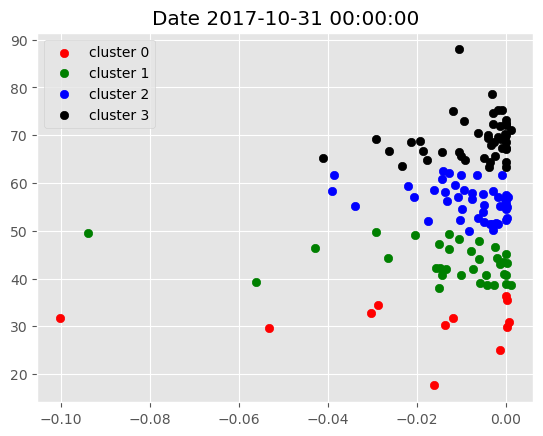

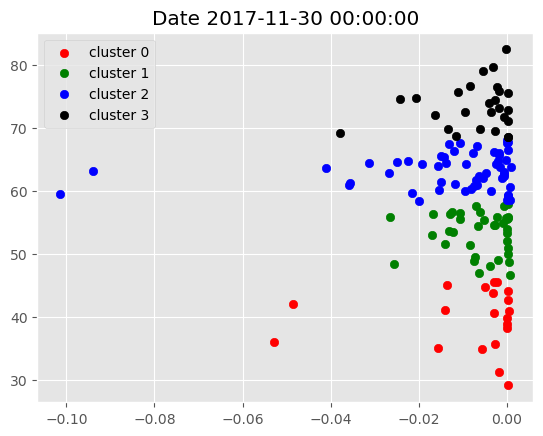

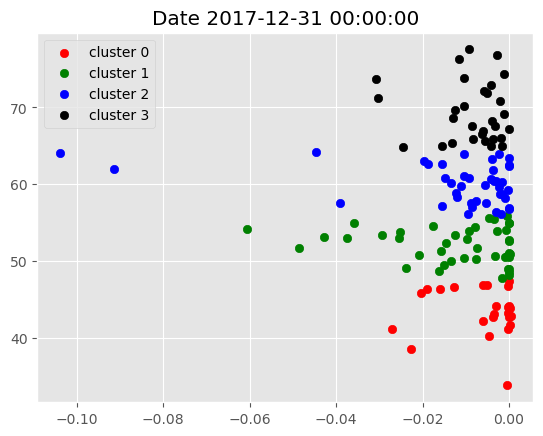

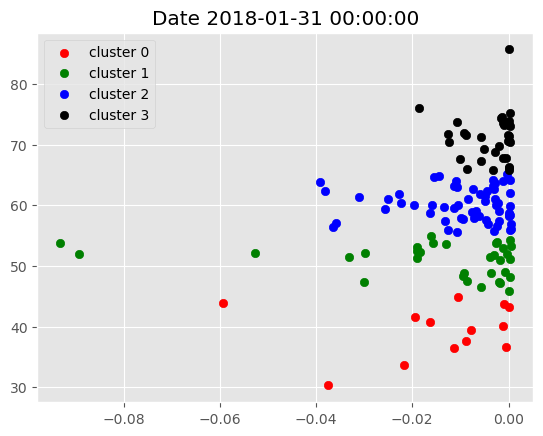

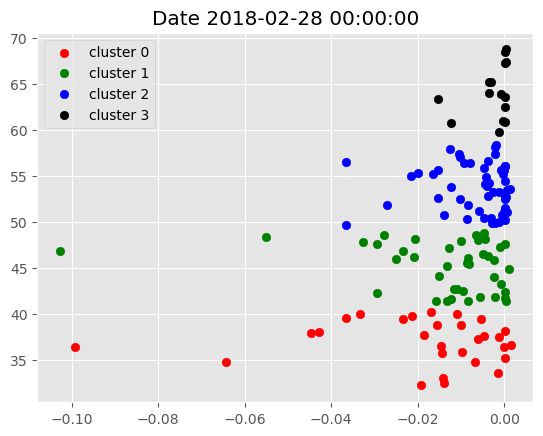

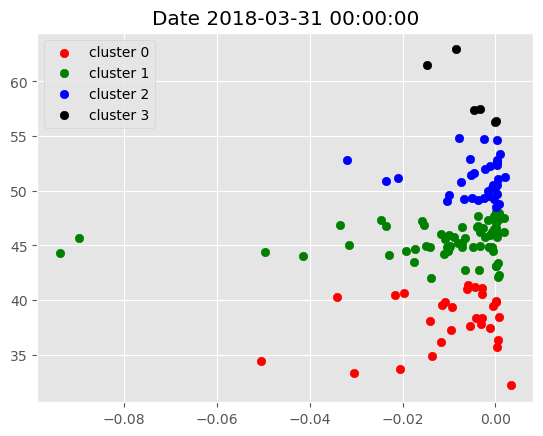

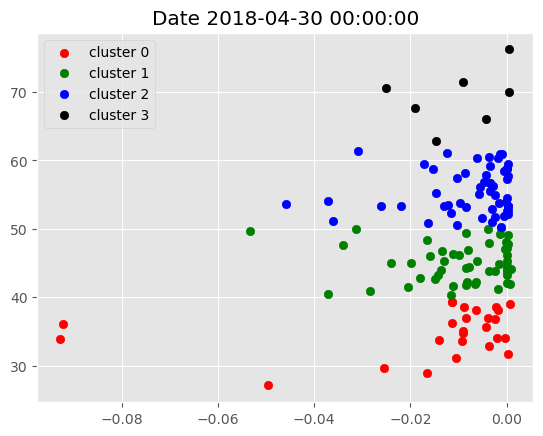

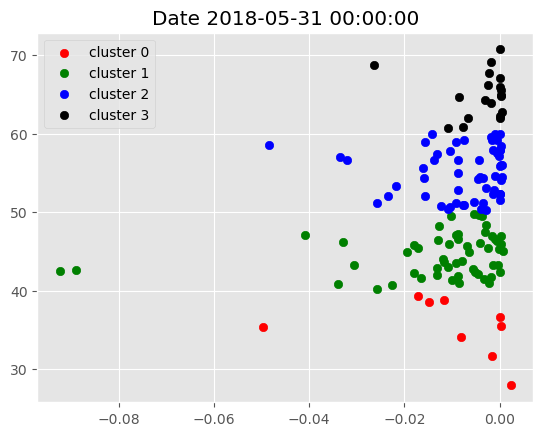

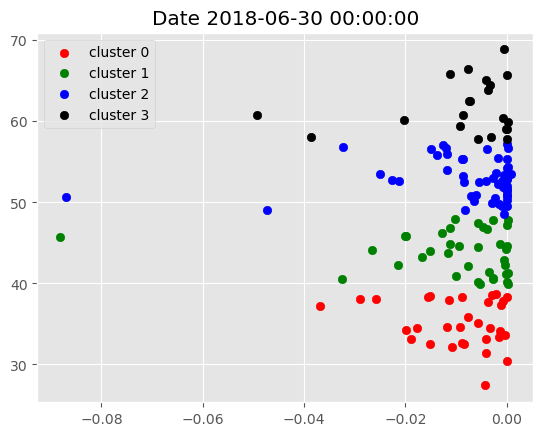

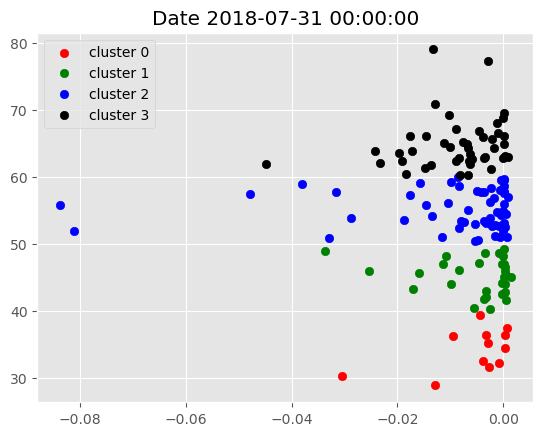

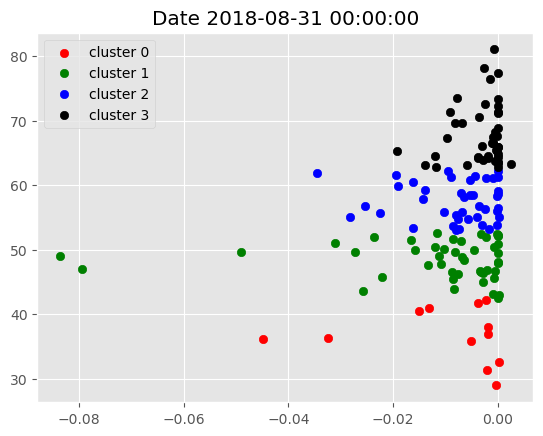

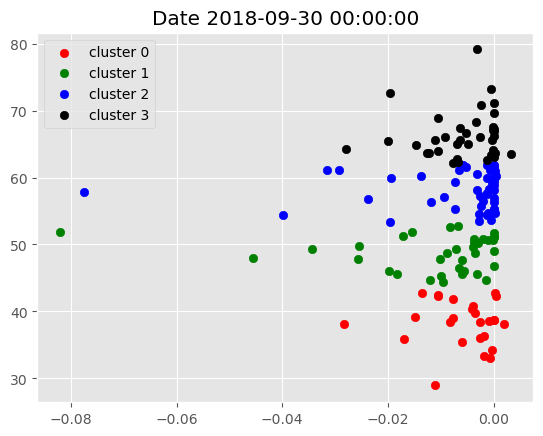

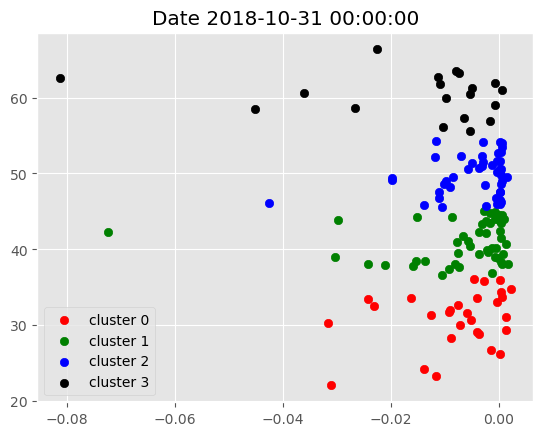

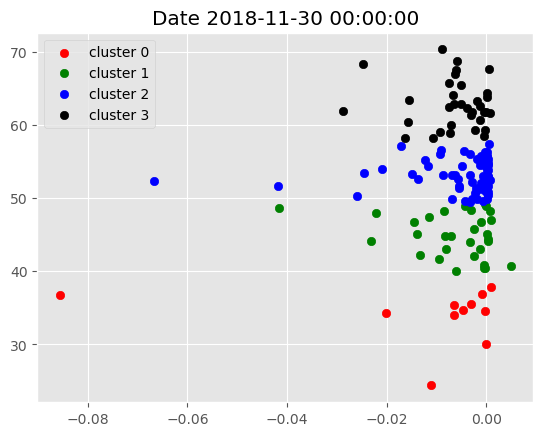

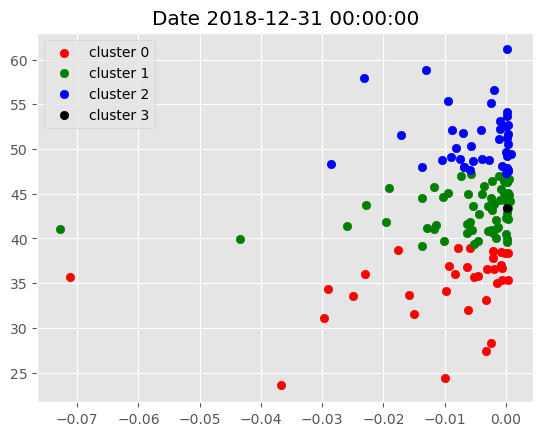

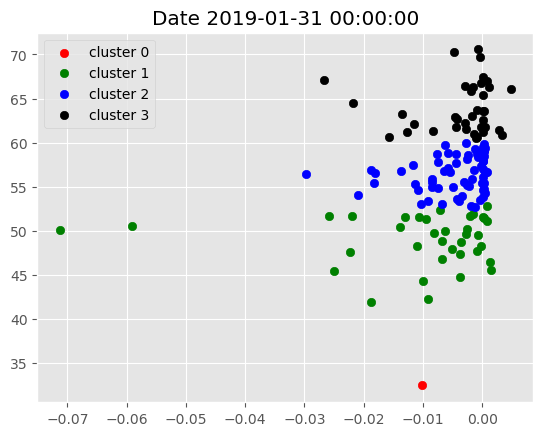

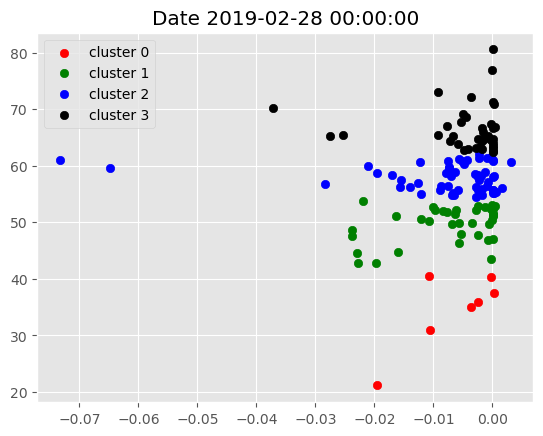

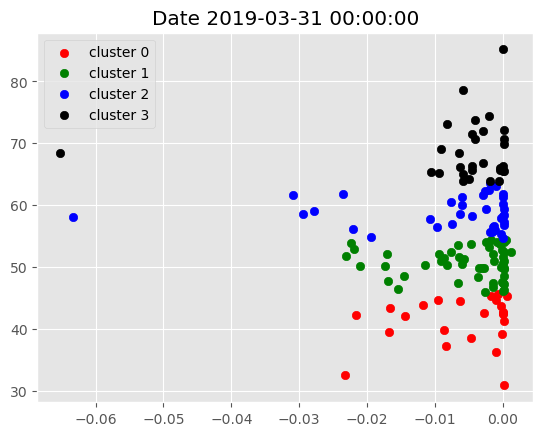

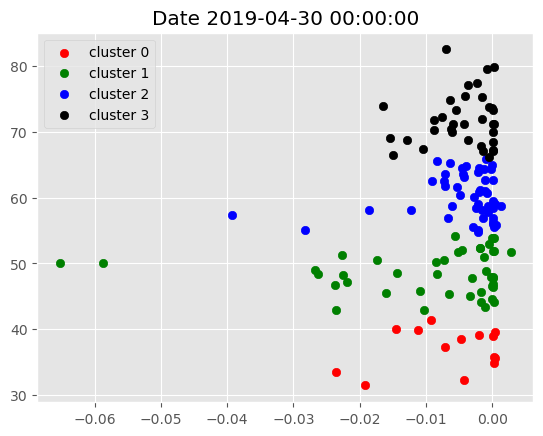

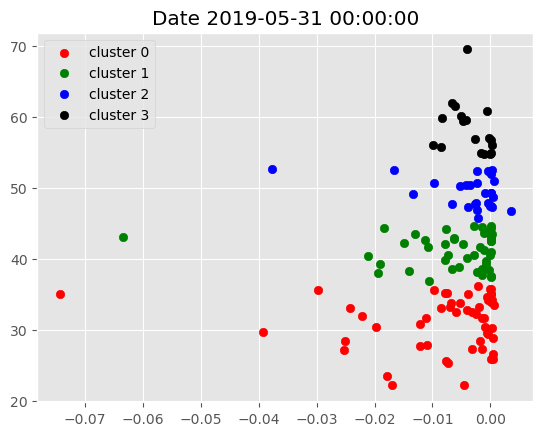

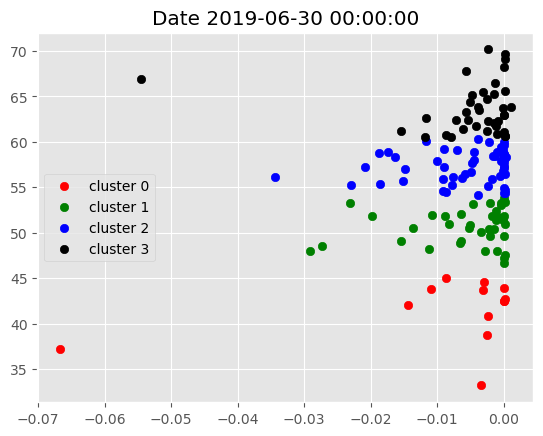

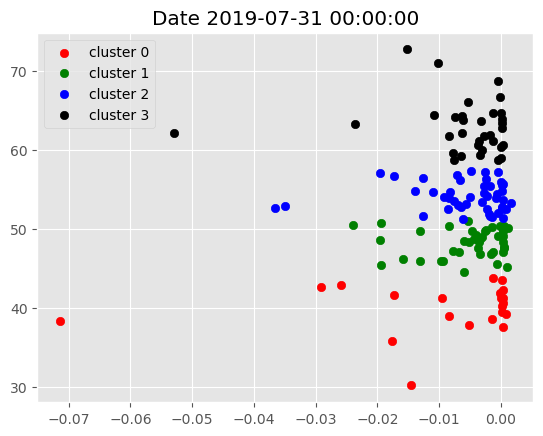

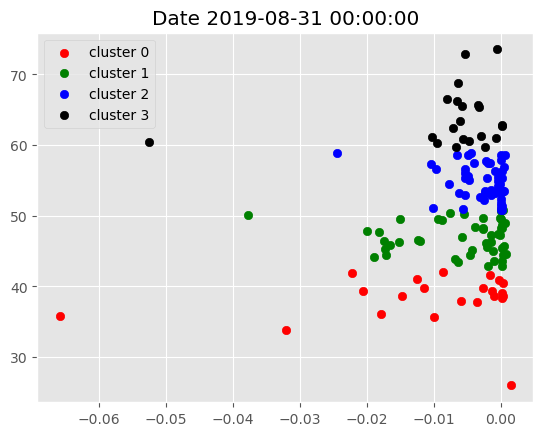

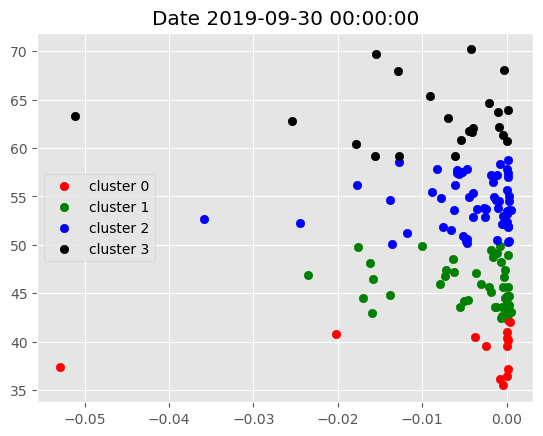

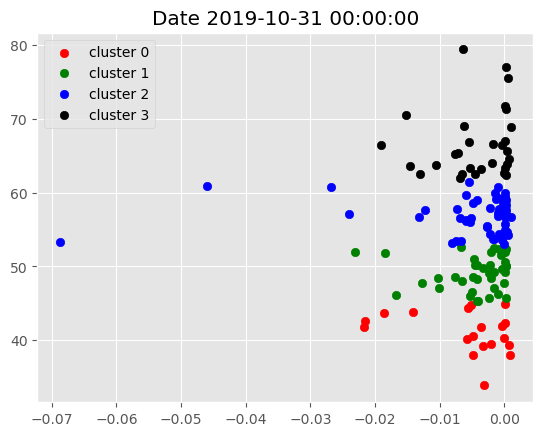

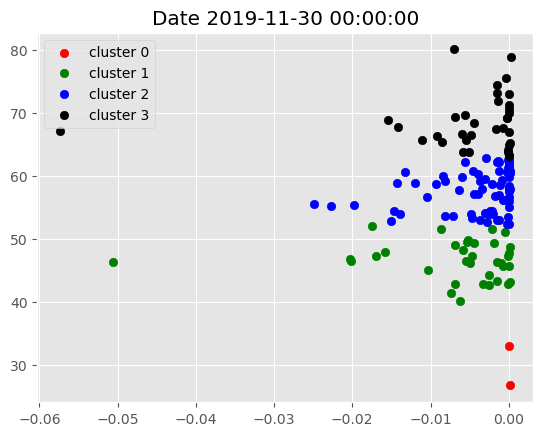

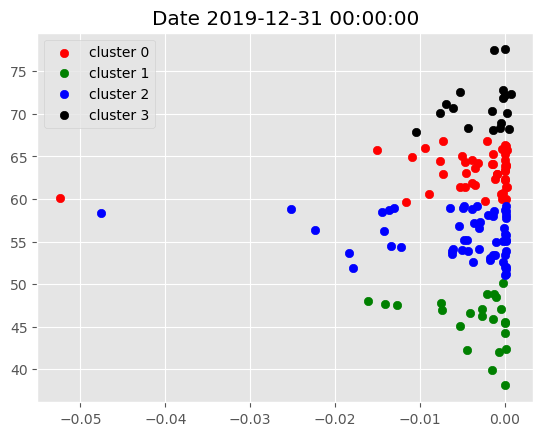

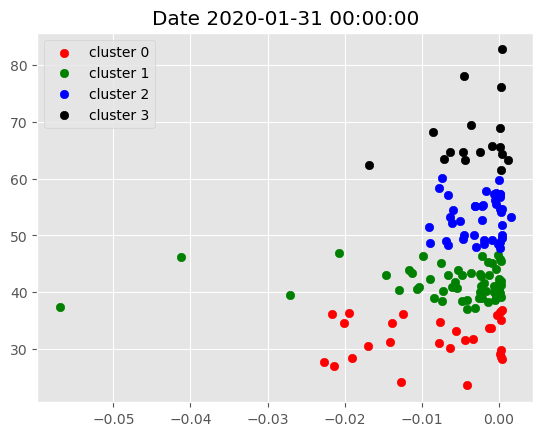

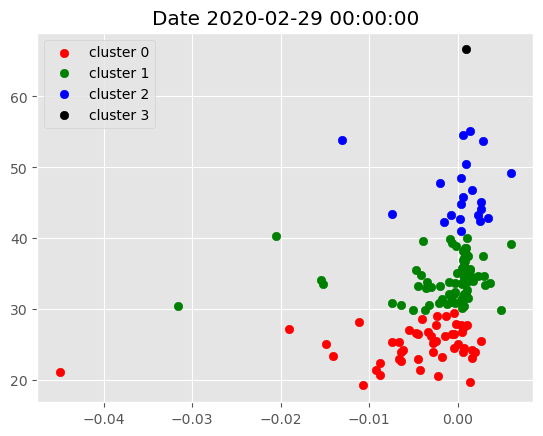

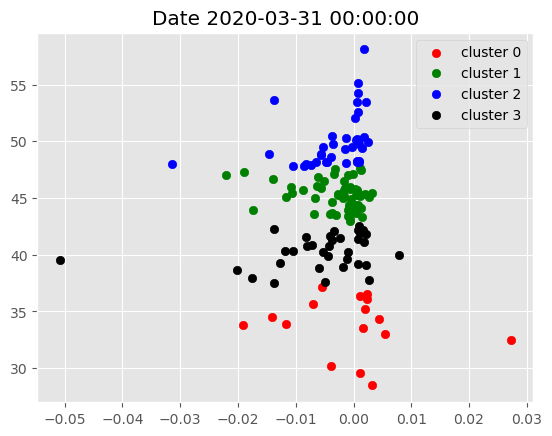

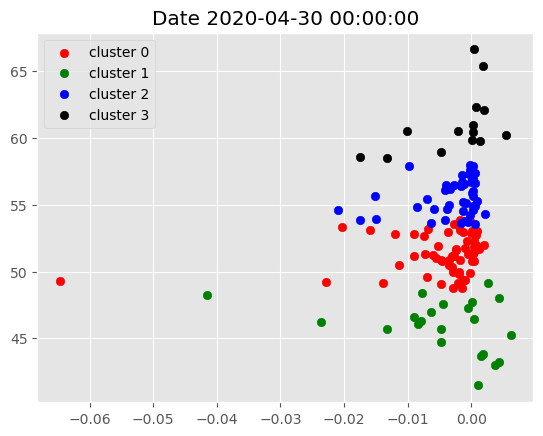

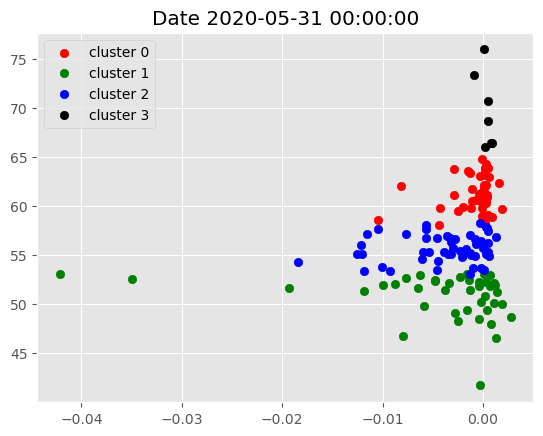

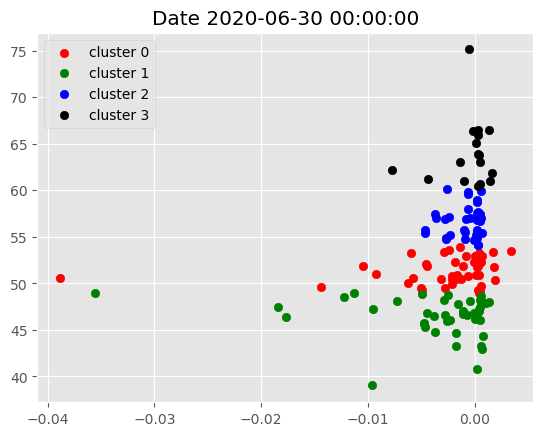

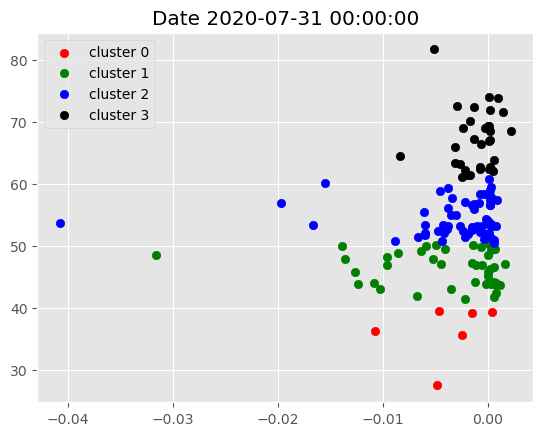

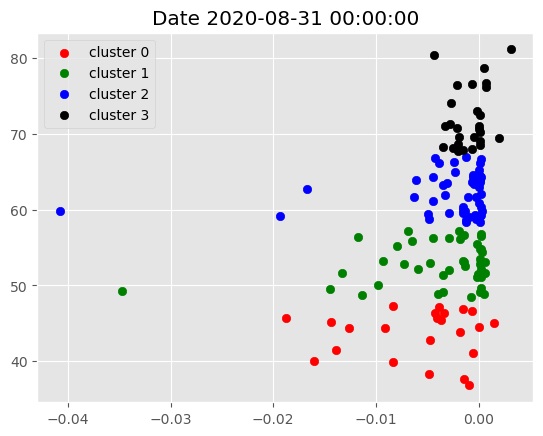

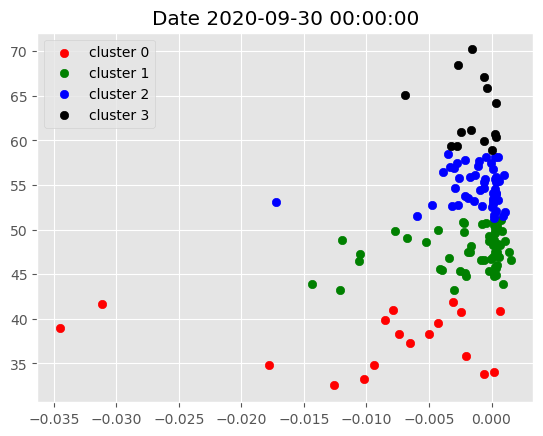

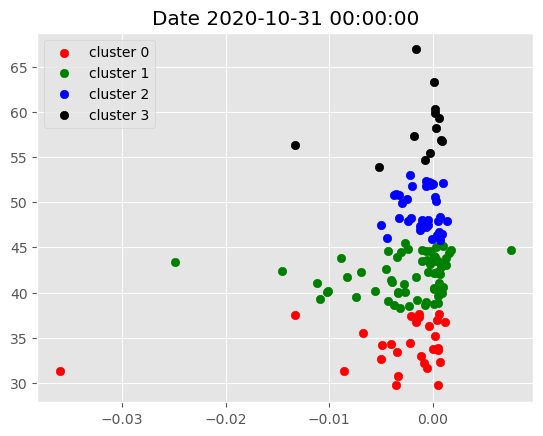

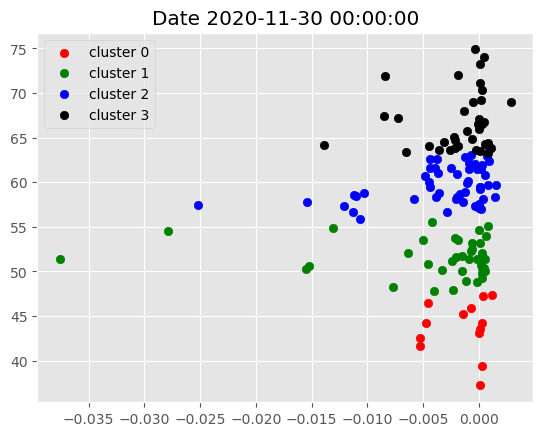

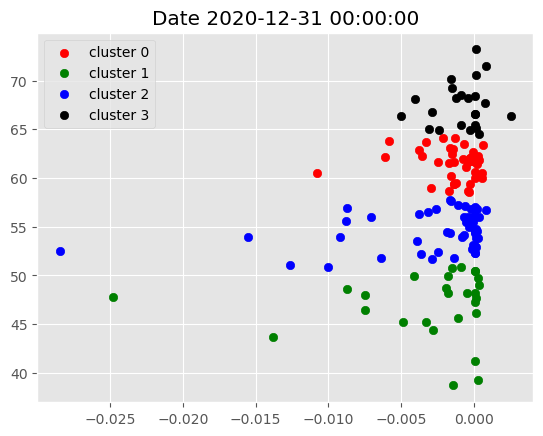

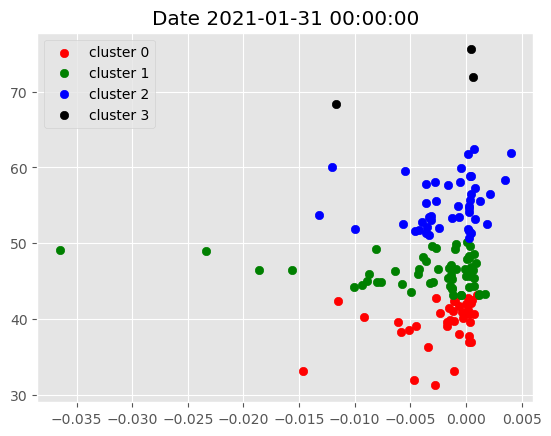

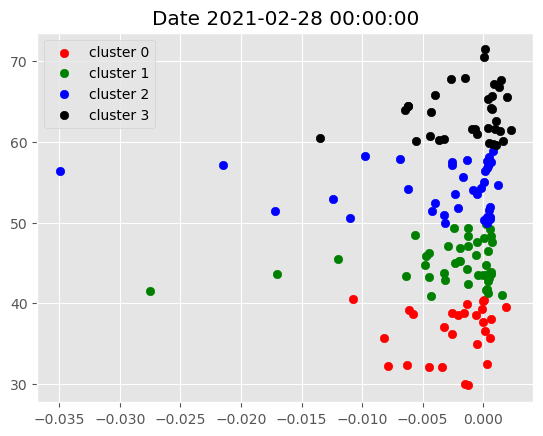

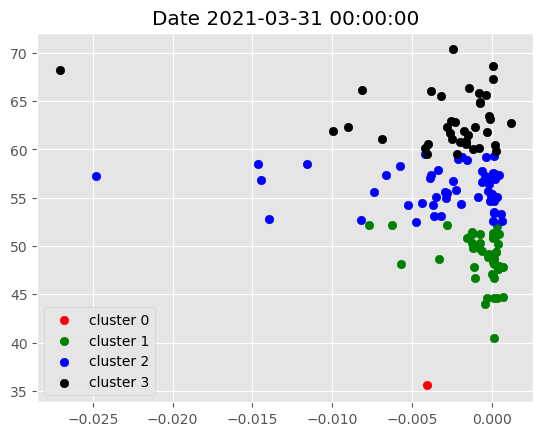

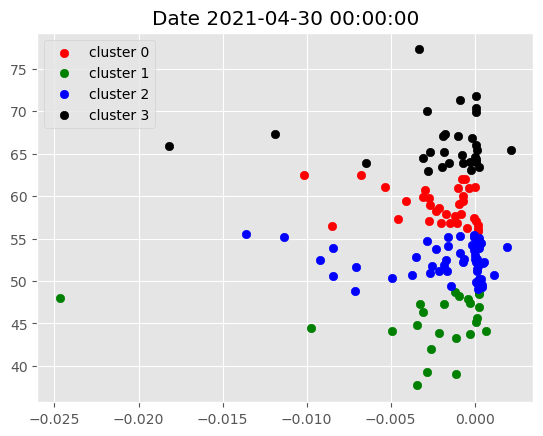

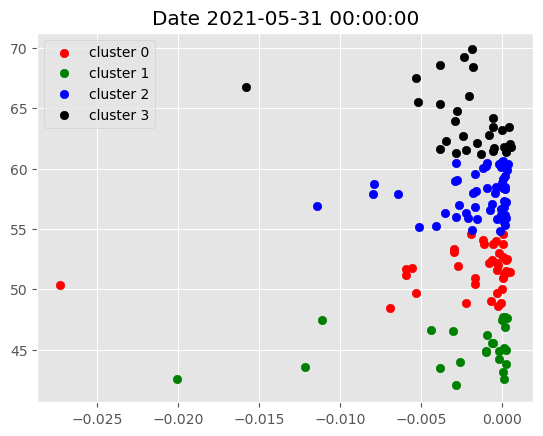

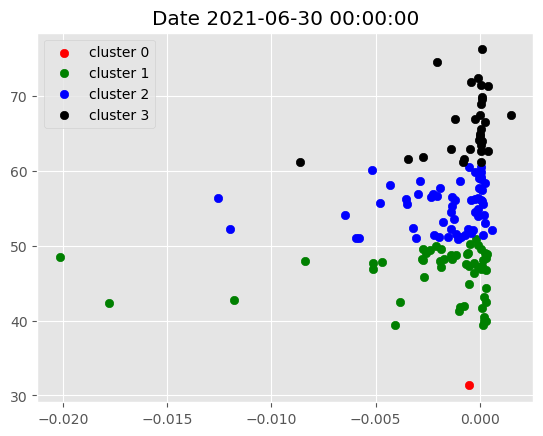

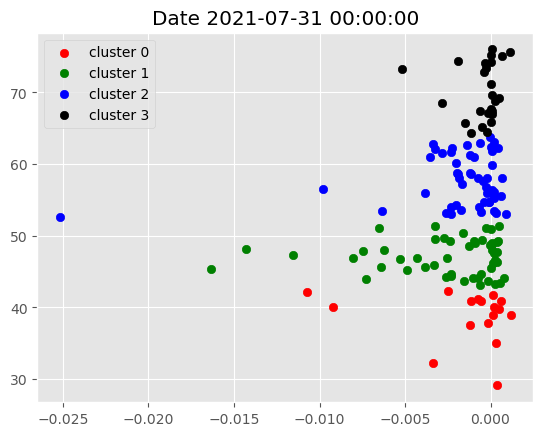

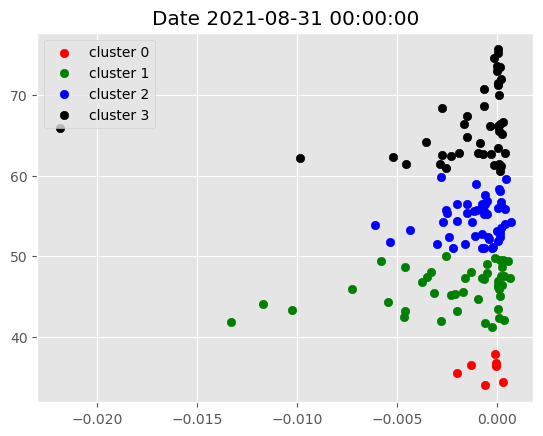

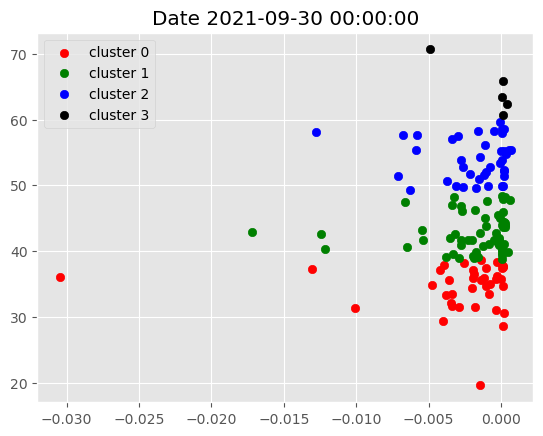

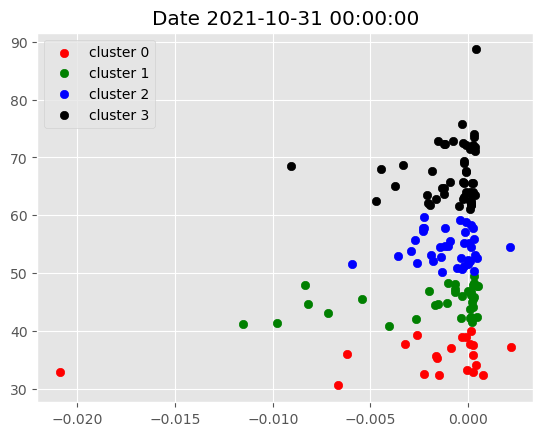

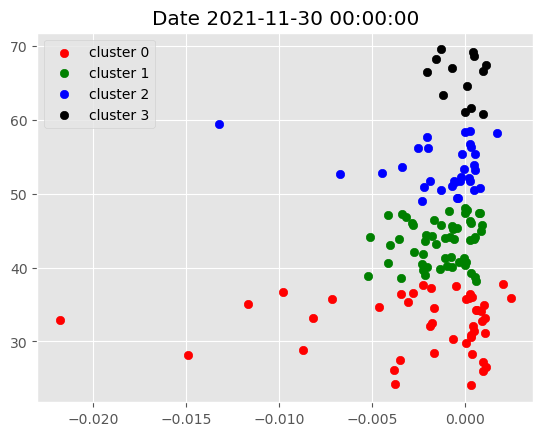

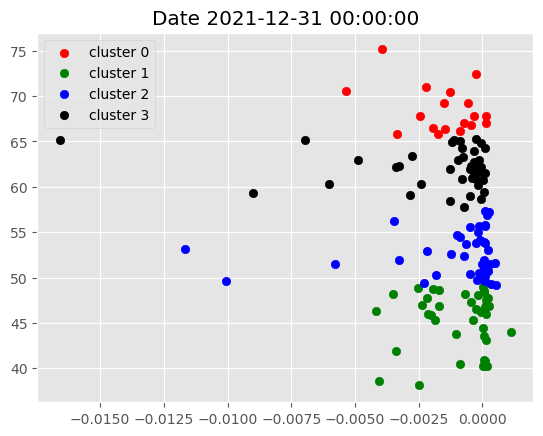

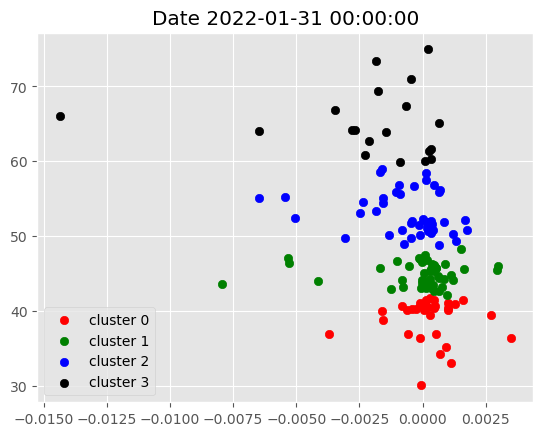

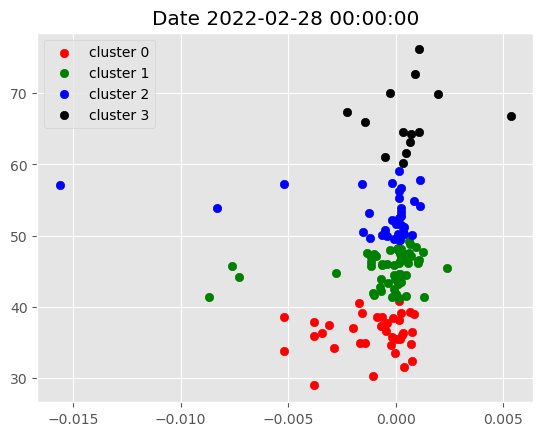

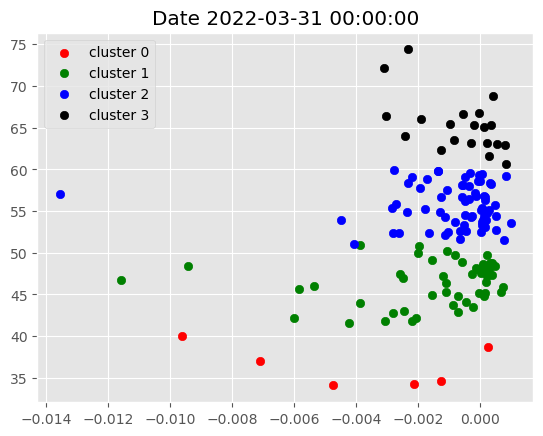

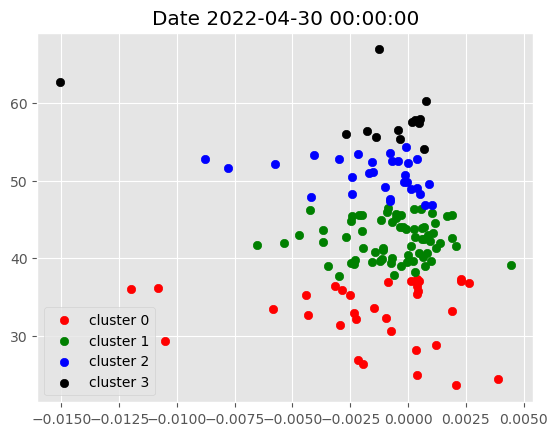

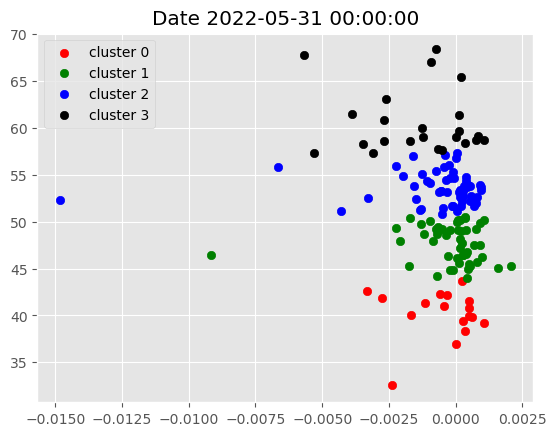

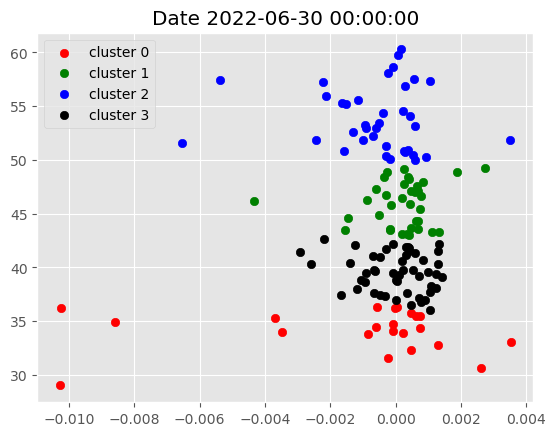

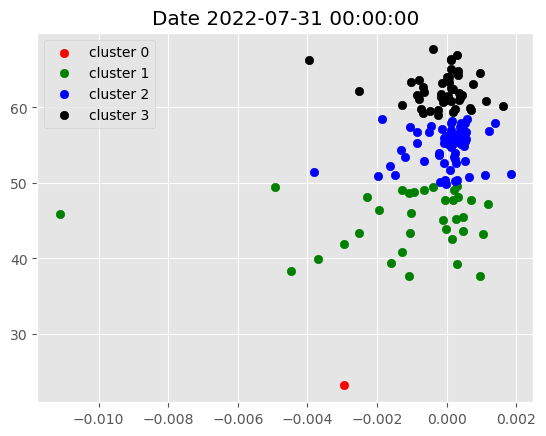

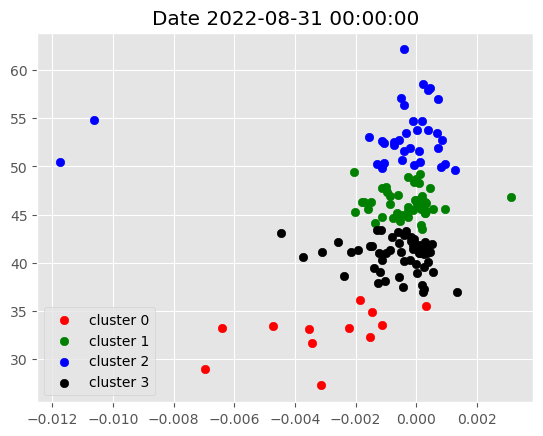

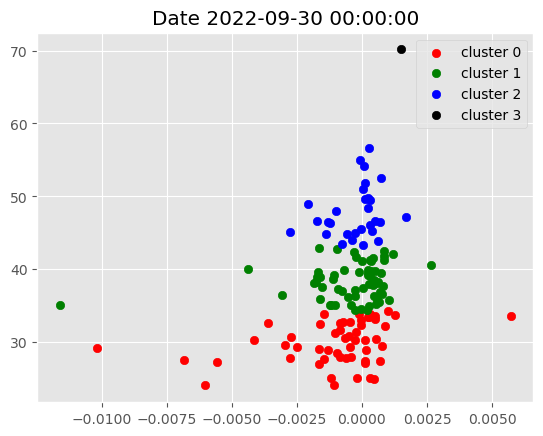

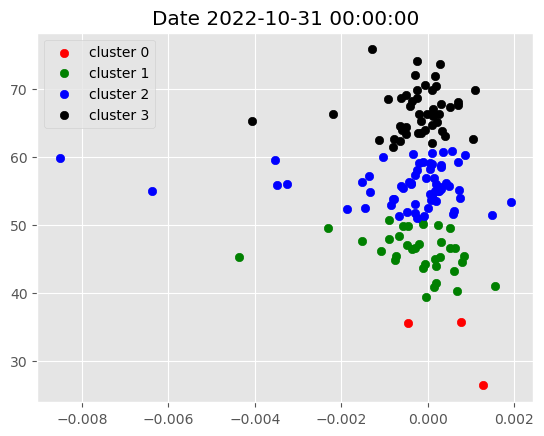

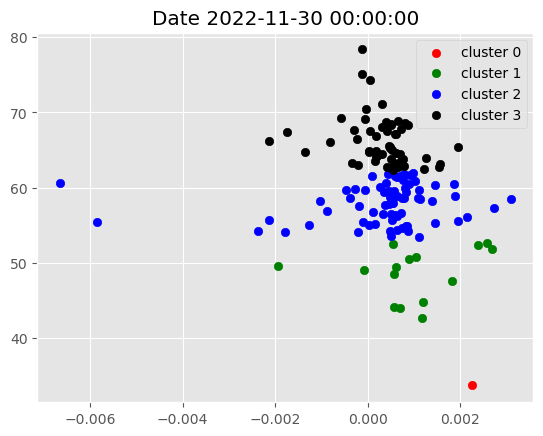

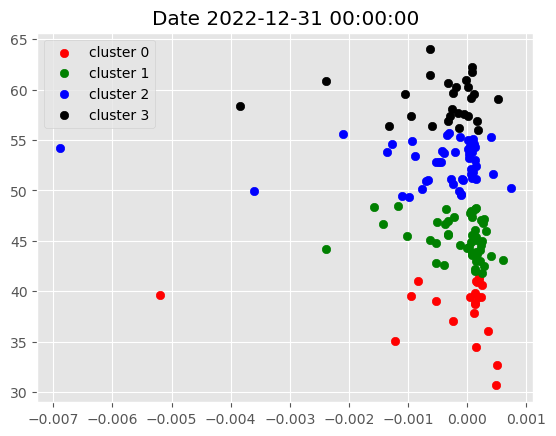

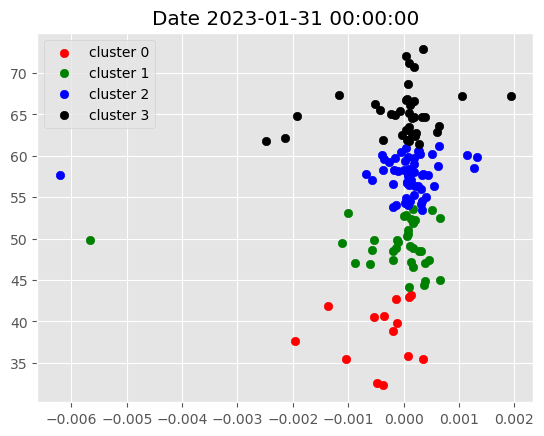

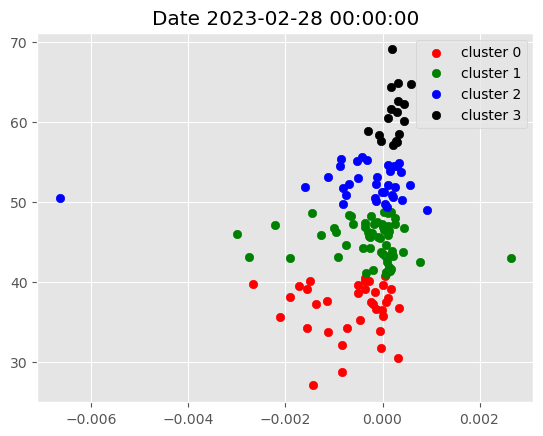

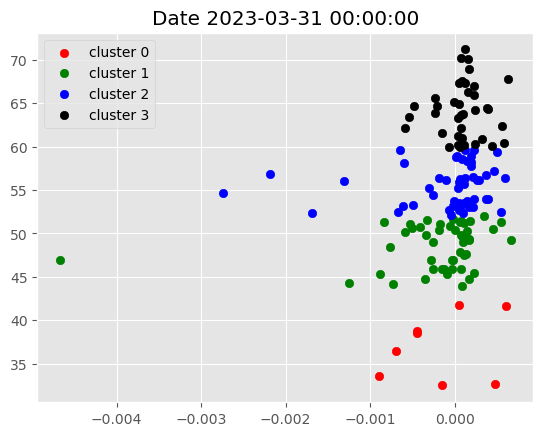

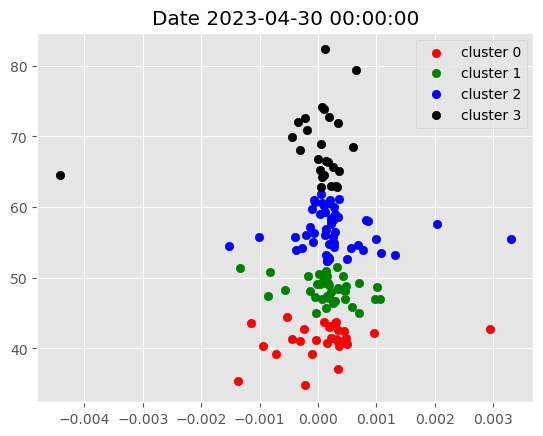

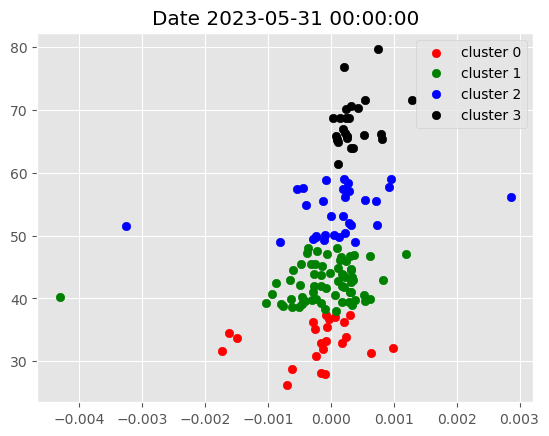

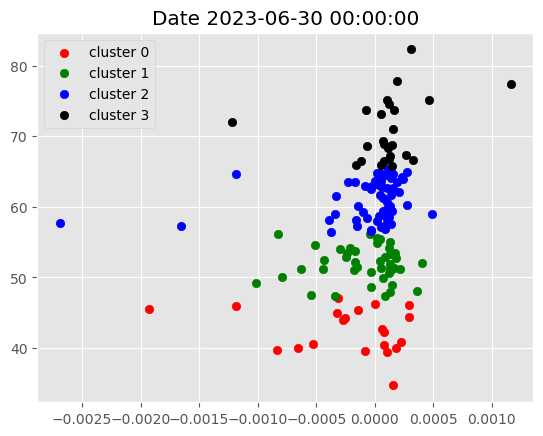

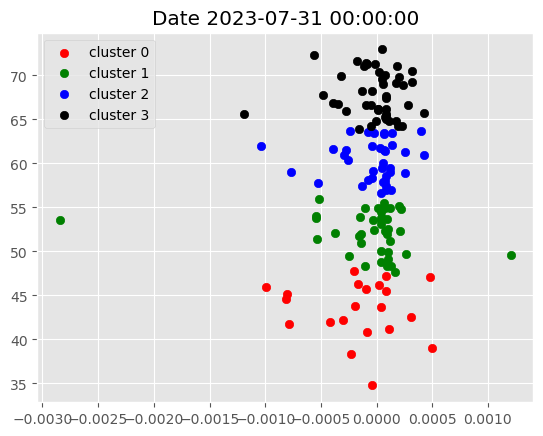

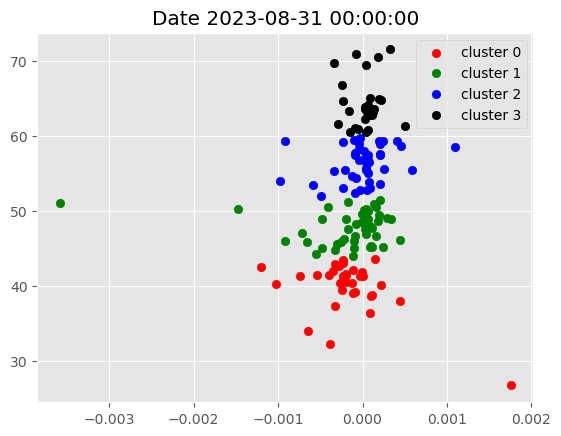

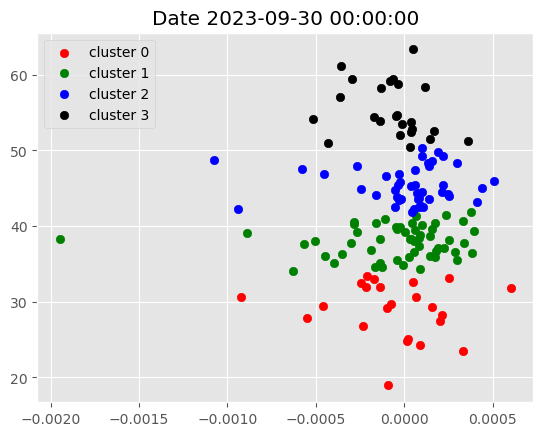

In [18]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    
    g = data.xs(i, level=0)
    
    plt.title(f'Date {i}')
    
    plot_clusters(g)

In [19]:
filtered_df = data[data['cluster']==3].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:
    
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()
    
fixed_dates

{'2017-11-01': ['AAPL',
  'ACN',
  'ADBE',
  'AMAT',
  'AMZN',
  'AVGO',
  'AXP',
  'BAC',
  'CAT',
  'COF',
  'COP',
  'CRM',
  'CTSH',
  'DE',
  'DHR',
  'DLTR',
  'ELV',
  'EOG',
  'GOOG',
  'GOOGL',
  'INTC',
  'ISRG',
  'JPM',
  'MA',
  'MAR',
  'MCD',
  'MET',
  'META',
  'MMM',
  'MPC',
  'MRO',
  'MSFT',
  'MU',
  'NEE',
  'NVDA',
  'NXPI',
  'ORCL',
  'PYPL',
  'SHW',
  'STZ',
  'TXN',
  'UNH',
  'V',
  'VLO',
  'WMT',
  'XOM'],
 '2017-12-01': ['AXP',
  'AZO',
  'BA',
  'COST',
  'CSCO',
  'DE',
  'DLTR',
  'ELV',
  'HD',
  'HON',
  'JPM',
  'KR',
  'LUV',
  'MAR',
  'MMM',
  'NKE',
  'ORLY',
  'OXY',
  'SCHW',
  'SYF',
  'UNH',
  'UNP',
  'VLO',
  'VZ',
  'WMT',
  'YUM'],
 '2018-01-01': ['ACN',
  'BA',
  'CAT',
  'COF',
  'CSCO',
  'CVX',
  'DE',
  'DG',
  'EOG',
  'FCX',
  'FDX',
  'HAL',
  'HD',
  'KR',
  'LOW',
  'LUV',
  'MAR',
  'MRO',
  'OXY',
  'PEP',
  'RTX',
  'STZ',
  'SYF',
  'TXN',
  'UAL',
  'UNP',
  'VLO',
  'VTRS',
  'WMT',
  'WYNN'],
 '2018-02-01': ['ABT',
  '

In [20]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0):
    
    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=252)
    
    cov = risk_models.sample_cov(prices=prices,
                                 frequency=252)
    
    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .1),
                           solver='SCS')
    
    weights = ef.max_sharpe()
    
    return ef.clean_weights()

In [21]:
stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end=data.index.get_level_values('date').unique()[-1])

new_df

[*********************100%%**********************]  176 of 176 completed


Price       Adj Close                                                 \
Ticker            AAL        AAPL        ABBV        ABNB        ABT   
Date                                                                   
2016-10-31  39.134327   26.212475   40.245121         NaN  34.293461   
2016-11-01  38.363201   25.739199   40.728531         NaN  34.127399   
2016-11-02  38.276463   25.762287   40.973839         NaN  33.821537   
2016-11-03  38.054203   25.486143   40.324490         NaN  33.541862   
2016-11-04  38.402081   25.256422   40.432713         NaN  34.162365   
...               ...         ...         ...         ...        ...   
2023-09-25  12.910000  175.386353  150.264954  134.139999  95.991318   
2023-09-26  12.700000  171.282578  149.545944  132.279999  94.770134   
2023-09-27  12.610000  169.758591  148.788055  134.029999  94.080750   
2023-09-28  12.920000  170.017578  147.933014  136.470001  96.631454   
2023-09-29  12.810000  170.535538  144.833466  137.210007  95.380714   

Price                                                                   ...  \
Ticker             ACN        ADBE         ADI         ADP        ADSK  ...   
Date                                                                    ...   
2016-10-31  103.569618  107.510002   55.107708   73.831512   72.279999  ...   
2016-11-01  103.480530  106.870003   54.677856   73.712799   70.099998  ...   
2016-11-02  105.681297  105.889999   54.729435   76.307838   68.680000  ...   
2016-11-03  104.202217  107.169998   54.892776   75.756607   67.610001  ...   
2016-11-04  104.451721  106.199997   54.531696   75.544594   69.440002  ...   
...                ...         ...         ...         ...         ...  ...   
2023-09-25  313.318970  511.600006  173.099823  235.844101  205.669998  ...   
2023-09-26  307.012878  506.299988  170.050873  233.112457  201.660004  ...   
2023-09-27  310.739197  502.600006  170.514618  238.408676  202.279999  ...   
2023-09-28  297.286835  504.670013  174.066818  239.076843  207.889999  ...   
2023-09-29  303.553406  509.899994  172.764343  236.394348  206.910004  ...   

Price        Volume                                                   \
Ticker         VRTX      VTRS        VZ       WBA      WDC       WFC   
Date                                                                   
2016-10-31  1928200   5473100  12459400   4662100  3363200  20115900   
2016-11-01  2458200   6488900  13229400   5130800  3821100  20020200   
2016-11-02  2580400   5947000  16488200   9783100  4216200  19566600   
2016-11-03  2371000  17832200  12605100   4586500  3192600  14982700   
2016-11-04  1902100   7932400  14410200   7023900  2705600  27391600   
...             ...       ...       ...       ...      ...       ...   
2023-09-25   698100   5595100  17616900   6891000  2685900  10624000   
2023-09-26   633600   5884000  18841600   7570500  3571100  15219400   
2023-09-27   860600   8614500  22083500  10182900  2547800  11815500   
2023-09-28   578900   8042500  18772100   7291500  3282000  12454600   
2023-09-29   896800   6365500  19759400  25659100  2512000  13119100   

Price                                              
Ticker           WMT     WYNN       XOM       YUM  
Date                                               
2016-10-31  19167000  1341600  16663800   5419197  
2016-11-01  26515800  3722300  13050600  12111800  
2016-11-02  22935900  2542400  11226100  10132900  
2016-11-03  20411700  9050400   8836500   7187800  
2016-11-04  21786300  3223800  13877100   4125200  
...              ...      ...       ...       ...  
2023-09-25  10459500  1387800  11316000   1048500  
2023-09-26  14435700  1454000  11805400   1500600  
2023-09-27  15711000  2050000  23976200   1922300  
2023-09-28  11617200  1290400  16808100   1722700  
2023-09-29  18842400  1326800  18810700   2610000  

[1740 rows x 1056 columns]

In [25]:
returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():

    try:

        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')
        
        cols = fixed_dates[start_date]
    
        optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')
    
        optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')

        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]

        success = False
        try:
    
            weights = optimize_weights(prices=optimization_df, lower_bound=round(1/(len(optimization_df.columns)*2),3))
    
            weights = pd.DataFrame(weights, index=pd.Series(0))

            success = True
        except:
            print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights' )

        if success==False:
            weigths = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                    index=optimization_df.columns.tolist(),
                                    columns=pd.Series(0)).T
    
        temp_df = returns_dataframe[start_date:end_date]
    
        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
            .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                  left_index=True,
                  right_index=True)\
            .reset_index().set_index(['Date','Ticker']).unstack().stack()
    
        temp_df.index.names = ['names', 'ticker']
    
        temp_df['weighted_return'] = temp_df['return']*temp_df['weight']
    
        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')
    
        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)

    except Exception as e:

        print(e)

portfolio_df

Max Sharpe Optimization failed for 2018-04-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-05-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2019-01-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2020-03-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2020-04-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2020-06-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2021-02-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2021-10-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-09-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-10-01, Continuing with Equal-Weights
'return'


Strategy Return
names                      
2017-11-01         0.001842
2017-11-02         0.003249
2017-11-03         0.006239
2017-11-06         0.003546
2017-11-07         0.002849
...                     ...
2023-09-25         0.003459
2023-09-26        -0.012075
2023-09-27         0.004926
2023-09-28         0.008140
2023-09-29        -0.007476

[1487 rows x 1 columns]

<Axes: xlabel='names'>

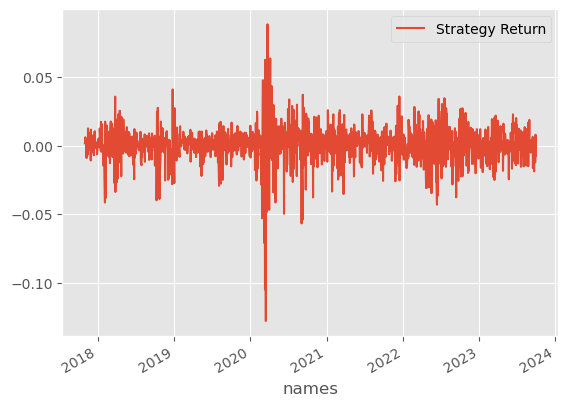

In [26]:
portfolio_df.plot()

In [27]:
spy = yf.download(tickers='SPY',
                  start='2015-01-01',
                  end=dt.date.today())

spy_ret = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close':'SPY Buy&Hold'}, axis=1)

portfolio_df = portfolio_df.merge(spy_ret,
                                  left_index=True,
                                  right_index=True)

portfolio_df

[*********************100%%**********************]  1 of 1 completed


Strategy Return  SPY Buy&Hold
2017-11-01         0.001842      0.001321
2017-11-02         0.003249      0.000388
2017-11-03         0.006239      0.003333
2017-11-06         0.003546      0.001547
2017-11-07         0.002849     -0.000696
...                     ...           ...
2023-09-25         0.003459      0.004196
2023-09-26        -0.012075     -0.014800
2023-09-27         0.004926      0.000399
2023-09-28         0.008140      0.005781
2023-09-29        -0.007476     -0.002430

[1487 rows x 2 columns]

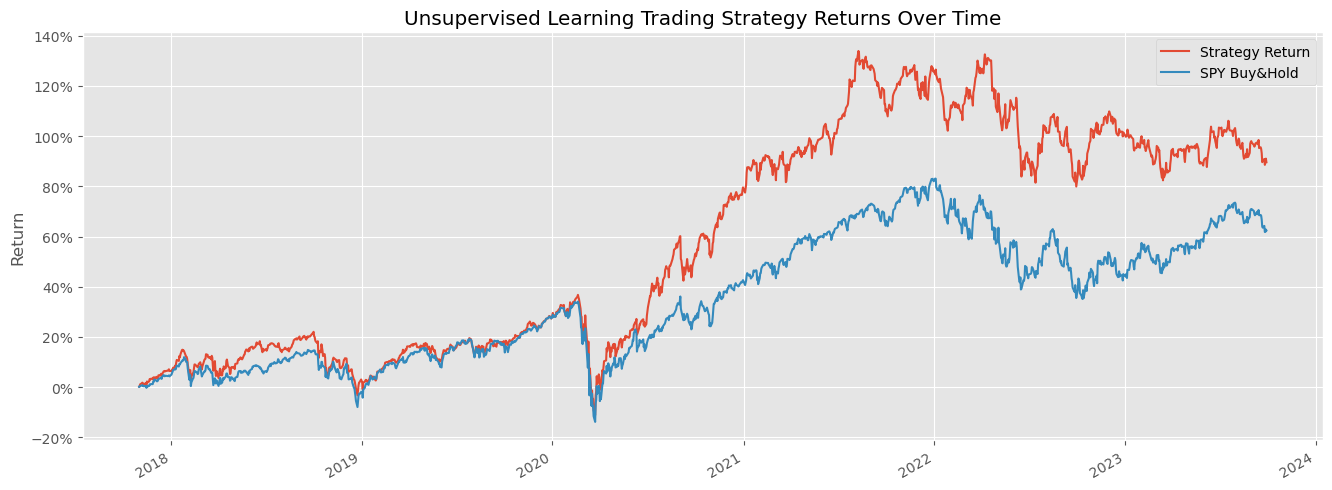

In [28]:
import matplotlib.ticker as mtick

plt.style.use('ggplot')

portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1

portfolio_cumulative_return[:'2023-09-29'].plot(figsize=(16,6))

plt.title('Unsupervised Learning Trading Strategy Returns Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()

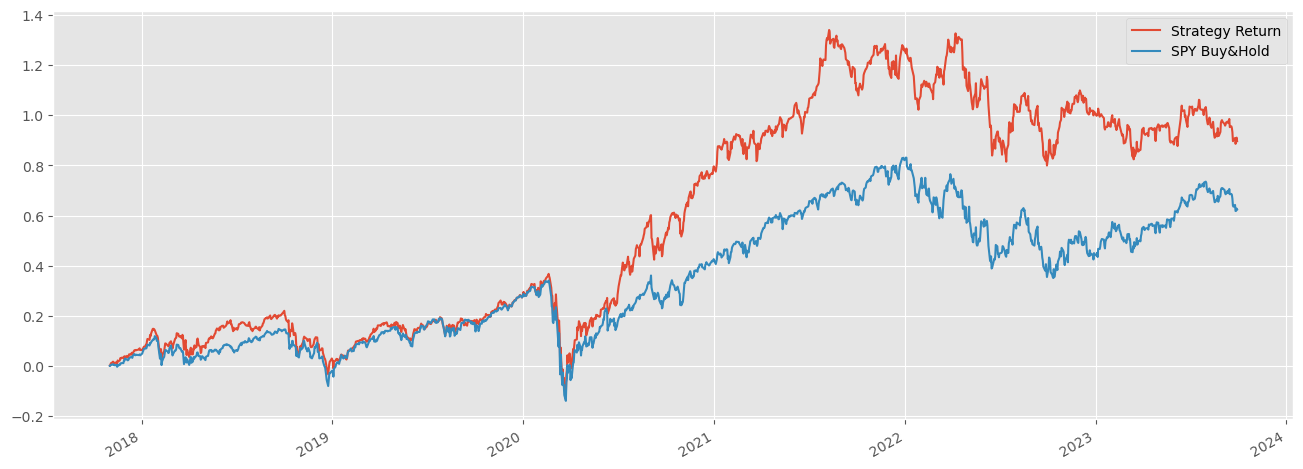

In [29]:
plt.style.use('ggplot')

portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1

portfolio_cumulative_return[:'2023-09-29'].plot(figsize=(16,6))

plt.show()

In [30]:
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

In [31]:
sp500

Symbol            Security             GICS Sector  \
0      MMM                  3M             Industrials   
1      AOS         A. O. Smith             Industrials   
2      ABT              Abbott             Health Care   
3     ABBV              AbbVie             Health Care   
4      ACN           Accenture  Information Technology   
..     ...                 ...                     ...   
498    XYL          Xylem Inc.             Industrials   
499    YUM         Yum! Brands  Consumer Discretionary   
500   ZBRA  Zebra Technologies  Information Technology   
501    ZBH       Zimmer Biomet             Health Care   
502    ZTS              Zoetis             Health Care   

                                GICS Sub-Industry    Headquarters Location  \
0                        Industrial Conglomerates    Saint Paul, Minnesota   
1                               Building Products     Milwaukee, Wisconsin   
2                           Health Care Equipment  North Chicago, Illinois   
3                                   Biotechnology  North Chicago, Illinois   
4                  IT Consulting & Other Services          Dublin, Ireland   
..                                            ...                      ...   
498  Industrial Machinery & Supplies & Components   White Plains, New York   
499                                   Restaurants     Louisville, Kentucky   
500            Electronic Equipment & Instruments   Lincolnshire, Illinois   
501                         Health Care Equipment          Warsaw, Indiana   
502                               Pharmaceuticals   Parsippany, New Jersey   

     Date added      CIK      Founded  
0    1957-03-04    66740         1902  
1    2017-07-26    91142         1916  
2    1957-03-04     1800         1888  
3    2012-12-31  1551152  2013 (1888)  
4    2011-07-06  1467373         1989  
..          ...      ...          ...  
498  2011-11-01  1524472         2011  
499  1997-10-06  1041061         1997  
500  2019-12-23   877212         1969  
501  2001-08-07  1136869         1927  
502  2013-06-21  1555280         1952  

[503 rows x 8 columns]

In [32]:
sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')

In [33]:
sp500

Symbol            Security             GICS Sector  \
0      MMM                  3M             Industrials   
1      AOS         A. O. Smith             Industrials   
2      ABT              Abbott             Health Care   
3     ABBV              AbbVie             Health Care   
4      ACN           Accenture  Information Technology   
..     ...                 ...                     ...   
498    XYL          Xylem Inc.             Industrials   
499    YUM         Yum! Brands  Consumer Discretionary   
500   ZBRA  Zebra Technologies  Information Technology   
501    ZBH       Zimmer Biomet             Health Care   
502    ZTS              Zoetis             Health Care   

                                GICS Sub-Industry    Headquarters Location  \
0                        Industrial Conglomerates    Saint Paul, Minnesota   
1                               Building Products     Milwaukee, Wisconsin   
2                           Health Care Equipment  North Chicago, Illinois   
3                                   Biotechnology  North Chicago, Illinois   
4                  IT Consulting & Other Services          Dublin, Ireland   
..                                            ...                      ...   
498  Industrial Machinery & Supplies & Components   White Plains, New York   
499                                   Restaurants     Louisville, Kentucky   
500            Electronic Equipment & Instruments   Lincolnshire, Illinois   
501                         Health Care Equipment          Warsaw, Indiana   
502                               Pharmaceuticals   Parsippany, New Jersey   

     Date added      CIK      Founded  
0    1957-03-04    66740         1902  
1    2017-07-26    91142         1916  
2    1957-03-04     1800         1888  
3    2012-12-31  1551152  2013 (1888)  
4    2011-07-06  1467373         1989  
..          ...      ...          ...  
498  2011-11-01  1524472         2011  
499  1997-10-06  1041061         1997  
500  2019-12-23   877212         1969  
501  2001-08-07  1136869         1927  
502  2013-06-21  1555280         1952  

[503 rows x 8 columns]

In [36]:
symbols_list = sp500['Symbol'].unique().tolist()
print(symbols_list)
start_date = pd.to_datetime(end_date)-pd.DateOffset(365*8)
print(start_date)

['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A', 'APD', 'ABNB', 'AKAM', 'ALB', 'ARE', 'ALGN', 'ALLE', 'LNT', 'ALL', 'GOOGL', 'GOOG', 'MO', 'AMZN', 'AMCR', 'AEE', 'AAL', 'AEP', 'AXP', 'AIG', 'AMT', 'AWK', 'AMP', 'AME', 'AMGN', 'APH', 'ADI', 'ANSS', 'AON', 'APA', 'AAPL', 'AMAT', 'APTV', 'ACGL', 'ADM', 'ANET', 'AJG', 'AIZ', 'T', 'ATO', 'ADSK', 'ADP', 'AZO', 'AVB', 'AVY', 'AXON', 'BKR', 'BALL', 'BAC', 'BK', 'BBWI', 'BAX', 'BDX', 'BRK-B', 'BBY', 'BIO', 'TECH', 'BIIB', 'BLK', 'BX', 'BA', 'BKNG', 'BWA', 'BXP', 'BSX', 'BMY', 'AVGO', 'BR', 'BRO', 'BF-B', 'BLDR', 'BG', 'CDNS', 'CZR', 'CPT', 'CPB', 'COF', 'CAH', 'KMX', 'CCL', 'CARR', 'CTLT', 'CAT', 'CBOE', 'CBRE', 'CDW', 'CE', 'COR', 'CNC', 'CNP', 'CF', 'CHRW', 'CRL', 'SCHW', 'CHTR', 'CVX', 'CMG', 'CB', 'CHD', 'CI', 'CINF', 'CTAS', 'CSCO', 'C', 'CFG', 'CLX', 'CME', 'CMS', 'KO', 'CTSH', 'CL', 'CMCSA', 'CAG', 'COP', 'ED', 'STZ', 'CEG', 'COO', 'CPRT', 'GLW', 'CPAY', 'CTVA', 'CSGP', 'COST', 'CTRA', 'CRWD', 'CCI', 'CSX', 'CMI', '

# RTSI

In [43]:
RTSI = pd.read_html('https://ru.wikipedia.org/wiki/%D0%98%D0%BD%D0%B4%D0%B5%D0%BA%D1%81_%D0%A0%D0%A2%D0%A1')[4]

In [44]:
RTSI

№    Код                                       Наименование  \
0    1   GAZP                                  ПАО "Газпром", ао   
1    2   SBER                                   ПАО Сбербанк, ао   
2    3  SBERP                                   ПАО Сбербанк, ап   
3    4   LKOH                                   ПАО "ЛУКОЙЛ", ао   
4    5   GMKN                   ПАО "ГМК "Норильский никель", ао   
5    6   YNDX           Яндекс Н.В., акции иностранного эмитента   
6    7   NVTK                                  ПАО "НОВАТЭК", ао   
7    8   TATN                 ПАО "Татнефть" им. В.Д. Шашина, ао   
8    9  TATNP                 ПАО "Татнефть" им. В.Д. Шашина, ап   
9   10   ROSN                             ПАО "НК "Роснефть", ао   
10  11   SNGS                           ПАО "Сургутнефтегаз", ао   
11  12  SNGSP                           ПАО "Сургутнефтегаз", ап   
12  13   MGNT                                   ПАО "Магнит", ао   
13  14   FIVE  Икс 5 Ритейл Груп Н.В.и, ДР иностранного эмите...   
14  15   MTSS                                      ПАО "МТС", ао   
15  16   POLY  Полиметалл Интернэшнл плс, акции иностранного ...   
16  17   ALRS                              АК "АЛРОСА" (ПАО), ао   
17  18   CHMF                               ПАО "Северсталь", ао   
18  19   PLZL                                    ПАО "Полюс", ао   
19  20   IRAO                                ПАО "Интер РАО", ао   
20  21   NLMK                                     ПАО "НЛМК", ао   
21  22   VTBR                                 Банк ВТБ (ПАО), ао   
22  23   MOEX                           ПАО Московская Биржа, ао   
23  24   PHOR                                  ПАО "ФосАгро", ао   
24  25  TRNFP                               ПАО "Транснефть", ап   
25  26   MAGN                                      ПАО "ММК", ао   
26  27   RTKM                               ПАО "Ростелеком", ао   
27  28   RUAL  Юнайтед Компани РУСАЛ Плс, акции иностранного ...   
28  29   AFLT                                 ПАО "Аэрофлот", ао   
29  30   PIKK                      ПАО "Группа Компаний ПИК", ао   
30  31   HYDR                                 ПАО "РусГидро", ао   
31  32   FEES                                  ПАО "ФСК ЕЭС", ао   
32  33   AFKS                              ПАО АФК "Система", ао   
33  34   LSRG                               ПАО "Группа ЛСР", ао   
34  35   CBOM                ПАО "МОСКОВСКИЙ КРЕДИТНЫЙ БАНК", ао   
35  36   UPRO                                   ПАО "Юнипро", ао   
36  37   DSKY                              ПАО "Детский мир", ао   
37  38   LNTA  Лента Лтд., ДР иностранного эмитента на акции ...   
38  39   SFIN             ПАО "САФМАР Финансовые инвестиции", ао   
39  40   RNFT                             ПАО НК "РуссНефть", ао   
40  41   MVID                                  ПАО "М.видео", ао   

   Количество выпущенных акций Коэффициент, учитывающий free-float  \
0               23 673 512 900                                 46%   
1               21 586 948 000                                 48%   
2                1 000 000 000                                100%   
3                  715 000 000                                 54%   
4                  158 245 476                                 38%   
5                  292 567 655                                 96%   
6                3 036 306 000                                 21%   
7                2 178 690 700                                 32%   
8                  147 508 500                                100%   
9               10 598 177 817                                 11%   
10              35 725 994 705                                 25%   
11               7 701 998 235                                 73%   
12                 101 911 355                                 71%   
13                 271 572 872                                 41%   
14               1 998 381 575                                 45%   
15                 470 183 4

In [46]:
symbols_list = RTSI['Код'].unique().tolist()
symbols_list

['GAZP',
 'SBER',
 'SBERP',
 'LKOH',
 'GMKN',
 'YNDX',
 'NVTK',
 'TATN',
 'TATNP',
 'ROSN',
 'SNGS',
 'SNGSP',
 'MGNT',
 'FIVE',
 'MTSS',
 'POLY',
 'ALRS',
 'CHMF',
 'PLZL',
 'IRAO',
 'NLMK',
 'VTBR',
 'MOEX',
 'PHOR',
 'TRNFP',
 'MAGN',
 'RTKM',
 'RUAL',
 'AFLT',
 'PIKK',
 'HYDR',
 'FEES',
 'AFKS',
 'LSRG',
 'CBOM',
 'UPRO',
 'DSKY',
 'LNTA',
 'SFIN',
 'RNFT',
 'MVID']

In [47]:
end_date = '2024-06-27'

In [54]:
start_date = pd.to_datetime(end_date)-pd.DateOffset(365*5)
start_date                                             

Timestamp('2019-06-29 00:00:00')

In [65]:
df = yf.download(tickers=symbols_list,
                 start=start_date,
                 end=end_date).stack()

[*********************100%%**********************]  41 of 41 completed

33 Failed downloads:
['SBER', 'RTKM', 'NLMK', 'LKOH', 'LNTA', 'FEES', 'VTBR', 'TRNFP', 'AFLT', 'GMKN', 'TATN', 'PHOR', 'POLY', 'MVID', 'PLZL', 'MTSS', 'SNGSP', 'LSRG', 'RNFT', 'NVTK', 'PIKK', 'MOEX', 'GAZP', 'SNGS', 'RUAL', 'TATNP', 'AFKS', 'SBERP', 'IRAO', 'CHMF', 'CBOM']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')
['DSKY', 'MAGN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2019-06-29 00:00:00 -> 2024-06-27)')


$DSKY: possibly delisted; No price data found  (1d 2019-06-29 00:00:00 -> 2024-06-27)
$MAGN: possibly delisted; No price data found  (1d 2019-06-29 00:00:00 -> 2024-06-27)


In [66]:
df

Price               Adj Close       Close        High         Low        Open  \
Date       Ticker                                                               
2019-07-01 ALRS     16.253773   18.900000   18.900000   18.900000   18.900000   
           FIVE    125.459999  125.459999  127.790001  122.839996  123.739998   
           MGNT      0.004500    0.004500    0.004500    0.004500    0.004500   
           ROSN      0.149000    0.149000    0.200000    0.138000    0.200000   
           SFIN      0.000300    0.000300    0.000300    0.000300    0.000300   
...                       ...         ...         ...         ...         ...   
2024-06-26 MGNT      0.000200    0.000200    0.000200    0.000200    0.000200   
           ROSN      0.014400    0.014400    0.014400    0.012100    0.012100   
           SFIN      0.000100    0.000100    0.000100    0.000100    0.000100   
           UPRO     77.529999   77.529999   77.809998   76.449997   76.730003   
           YNDX     18.940001   18.940001   18.940001   18.940001   18.940001   

Price                 Volume  
Date       Ticker             
2019-07-01 ALRS        200.0  
           FIVE    1600900.0  
           MGNT          0.0  
           ROSN      39000.0  
           SFIN          0.0  
...                      ...  
2024-06-26 MGNT          0.0  
           ROSN       2100.0  
           SFIN          0.0  
           UPRO    2225200.0  
           YNDX          0.0  

[9535 rows x 6 columns]

In [67]:
df.index.names = ['date', 'ticker']

df.columns = df.columns.str.lower()

df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2019-07-01 ALRS     16.253773   18.900000   18.900000   18.900000   18.900000   
           FIVE    125.459999  125.459999  127.790001  122.839996  123.739998   
           MGNT      0.004500    0.004500    0.004500    0.004500    0.004500   
           ROSN      0.149000    0.149000    0.200000    0.138000    0.200000   
           SFIN      0.000300    0.000300    0.000300    0.000300    0.000300   
...                       ...         ...         ...         ...         ...   
2024-06-26 MGNT      0.000200    0.000200    0.000200    0.000200    0.000200   
           ROSN      0.014400    0.014400    0.014400    0.012100    0.012100   
           SFIN      0.000100    0.000100    0.000100    0.000100    0.000100   
           UPRO     77.529999   77.529999   77.809998   76.449997   76.730003   
           YNDX     18.940001   18.940001   18.940001   18.940001   18.940001   

Price                 volume  
date       ticker             
2019-07-01 ALRS        200.0  
           FIVE    1600900.0  
           MGNT          0.0  
           ROSN      39000.0  
           SFIN          0.0  
...                      ...  
2024-06-26 MGNT          0.0  
           ROSN       2100.0  
           SFIN          0.0  
           UPRO    2225200.0  
           YNDX          0.0  

[9535 rows x 6 columns]

In [68]:
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
                                                          
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])
                                                          
df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                        low=stock_data['low'],
                        close=stock_data['close'],
                        length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

df['dollar_volume'] = (df['adj close']*df['volume'])/1e6

df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2019-07-01 ALRS     16.253773   18.900000   18.900000   18.900000   18.900000   
           FIVE    125.459999  125.459999  127.790001  122.839996  123.739998   
           MGNT      0.004500    0.004500    0.004500    0.004500    0.004500   
           ROSN      0.149000    0.149000    0.200000    0.138000    0.200000   
           SFIN      0.000300    0.000300    0.000300    0.000300    0.000300   
...                       ...         ...         ...         ...         ...   
2024-06-26 MGNT      0.000200    0.000200    0.000200    0.000200    0.000200   
           ROSN      0.014400    0.014400    0.014400    0.012100    0.012100   
           SFIN      0.000100    0.000100    0.000100    0.000100    0.000100   
           UPRO     77.529999   77.529999   77.809998   76.449997   76.730003   
           YNDX     18.940001   18.940001   18.940001   18.940001   18.940001   

Price                 volume  garman_klass_vol        rsi    bb_low    bb_mid  \
date       ticker                                                               
2019-07-01 ALRS        200.0         -0.008789        NaN       NaN       NaN   
           FIVE    1600900.0          0.000707        NaN       NaN       NaN   
           MGNT          0.0          0.000000        NaN       NaN       NaN   
           ROSN      39000.0          0.035370        NaN       NaN       NaN   
           SFIN          0.0          0.000000        NaN       NaN       NaN   
...                      ...               ...        ...       ...       ...   
2024-06-26 MGNT          0.0          0.000000   0.000069  0.000200  0.000200   
           ROSN       2100.0          0.003443  43.797161  0.011414  0.015940   
           SFIN          0.0          0.000000   3.372726  0.000100  0.000100   
           UPRO    2225200.0          0.000114  66.393075  4.233956  4.317595   
           YNDX          0.0          0.000000  24.165779  2.992728  2.992728   

Price               bb_high       atr      macd  dollar_volume  
date       ticker                                               
2019-07-01 ALRS         NaN       NaN       NaN       0.003251  
           FIVE         NaN       NaN       NaN     200.848913  
           MGNT         NaN       NaN       NaN       0.000000  
           ROSN         NaN       NaN       NaN       0.005811  
           SFIN         NaN       NaN       NaN       0.000000  
...                     ...       ...       ...            ...  
2024-06-26 MGNT    0.000200 -0.516733  0.015952       0.000000  
           ROSN    0.020465 -0.857683  0.035416       0.000030  
           SFIN    0.000100 -0.549549  0.000739       0.000000  
           UPRO    4.401234  0.029672  1.320001     172.519753  
           YNDX    2.992728 -0.988202  0.073831       0.000000  

[9535 rows x 14 columns]

## 3. Aggregate to monthly level and filter top 150 most liquid stocks for each month.

In [69]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open',
                                                          'high', 'low', 'close']]

data = (pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
                   df.unstack()[last_cols].resample('M').last().stack('ticker')],
                  axis=1)).dropna()

data

dollar_volume   adj close  garman_klass_vol        rsi  \
date       ticker                                                           
2019-08-31 ALRS         0.101016   16.950365         -0.008789  54.611438   
           FIVE       149.698006  122.870003          0.000361  56.029515   
           MGNT         0.000792    0.005800          0.000000  53.493674   
           ROSN         0.003194    0.197000          0.001594  64.601276   
           SFIN         0.000050    0.000500          0.000000  48.956086   
...                          ...         ...               ...        ...   
2024-06-30 ROSN         0.001262    0.014400          0.003443  43.797161   
           SFIN         0.000000    0.000100          0.000000   3.372726   
           UPRO       272.122310   77.529999          0.000114  66.393075   
           YNDX         0.000000   18.940001          0.000000  24.165779   
           HYDR         1.077426   26.500000          0.000064  37.962467   

                     bb_low    bb_mid   bb_high       atr      macd  
date       ticker                                                    
2019-08-31 ALRS    2.850097  2.884154  2.918211 -1.907572  0.274518  
           FIVE    4.638400  4.734095  4.829791 -0.648455  0.053243  
           MGNT    0.001824  0.005165  0.008506  0.350320  0.418652  
           ROSN    0.113239  0.142926  0.172613  0.915561  1.819853  
           SFIN    0.000192  0.000625  0.001057 -0.524070  0.032252  
...                     ...       ...       ...       ...       ...  
2024-06-30 ROSN    0.011414  0.015940  0.020465 -0.857683  0.035416  
           SFIN    0.000100  0.000100  0.000100 -0.549549  0.000739  
           UPRO    4.233956  4.317595  4.401234  0.029672  1.320001  
           YNDX    2.992728  2.992728  2.992728 -0.988202  0.073831  
           HYDR    3.287684  3.440799  3.593914 -1.140653 -0.004184  

[448 rows x 9 columns]

In [70]:
data['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())

data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))

data = data[data['dollar_vol_rank']<10].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2020-07-31 ALRS     17.162849         -0.006464  50.207235  2.869123   
           FIVE    108.910004          0.000616  54.682448  4.576994   
           MGNT      0.015000          0.000000  57.103939  0.003458   
           ROSN      0.083990          0.100920  65.332627  0.036006   
           SFIN      0.018500          0.010249  61.313624  0.008478   
...                       ...               ...        ...       ...   
2024-06-30 ROSN      0.014400          0.003443  43.797161  0.011414   
           SFIN      0.000100          0.000000   3.372726  0.000100   
           UPRO     77.529999          0.000114  66.393075  4.233956   
           YNDX     18.940001          0.000000  24.165779  2.992728   
           HYDR     26.500000          0.000064  37.962467  3.287684   

                     bb_mid   bb_high       atr      macd  
date       ticker                                          
2020-07-31 ALRS    2.901898  2.934673 -0.499320  0.152381  
           FIVE    4.665599  4.754205 -1.227978  0.453963  
           MGNT    0.014356  0.025255  0.451792  0.967095  
           ROSN    0.052763  0.069520  0.648654  1.073219  
           SFIN    0.016275  0.024072  1.255204  1.791847  
...                     ...       ...       ...       ...  
2024-06-30 ROSN    0.015940  0.020465 -0.857683  0.035416  
           SFIN    0.000100  0.000100 -0.549549  0.000739  
           UPRO    4.317595  4.401234  0.029672  1.320001  
           YNDX    2.992728  2.992728 -0.988202  0.073831  
           HYDR    3.440799  3.593914 -1.140653 -0.004184  

[360 rows x 8 columns]

## 4. Calculate Monthly Returns for different time horizons as features.

In [71]:
def calculate_returns(df):

    outlier_cutoff = 0.005

    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:

        df[f'return_{lag}m'] = (df['adj close']
                              .pct_change(lag)
                              .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                     upper=x.quantile(1-outlier_cutoff)))
                              .add(1)
                              .pow(1/lag)
                              .sub(1))
    return df
    
    
data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()
data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2021-07-31 ALRS     25.296385         -0.005192  41.108950  3.263036   
           FIVE    194.419998          0.000314  53.014060  5.211115   
           MGNT      0.019580          0.000000  48.200038  0.007244   
           ROSN      0.180000          0.000098  71.247853  0.164031   
           SFIN      0.003500          0.000000  46.959327 -0.003132   
...                       ...               ...        ...       ...   
2024-06-30 ROSN      0.014400          0.003443  43.797161  0.011414   
           SFIN      0.000100          0.000000   3.372726  0.000100   
           UPRO     77.529999          0.000114  66.393075  4.233956   
           YNDX     18.940001          0.000000  24.165779  2.992728   
           HYDR     26.500000          0.000064  37.962467  3.287684   

                     bb_mid   bb_high       atr      macd  return_1m  \
date       ticker                                                      
2021-07-31 ALRS    3.298113  3.333190  1.064430 -1.327244  -0.036539   
           FIVE    5.258172  5.305229 -0.049996  0.114209   0.005950   
           MGNT    0.019082  0.030920  1.444071 -0.492330   1.797143   
           ROSN    0.165239  0.166447 -1.044104  0.615955   0.000000   
           SFIN    0.003140  0.009412 -0.034574 -0.198350   0.129032   
...                     ...       ...       ...       ...        ...   
2024-06-30 ROSN    0.015940  0.020465 -0.857683  0.035416  -0.242105   
           SFIN    0.000100  0.000100 -0.549549  0.000739   0.000000   
           UPRO    4.317595  4.401234  0.029672  1.320001   0.108079   
           YNDX    2.992728  2.992728 -0.988202  0.073831   0.000000   
           HYDR    3.440799  3.593914 -1.140653 -0.004184  -0.206587   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2021-07-31 ALRS    -0.076738  -0.007747   0.026915   0.031260    0.032854  
           FIVE     0.027590  -0.011476   0.016988   0.042792    0.049477  
           MGNT    -0.190772  -0.246675  -0.112247   0.110879    0.022453  
           ROSN     0.095445   0.216440   0.200937   0.155119    0.065582  
           SFIN    -0.163340  -0.295270  -0.215374  -0.155381   -0.129555  
...                      ...        ...        ...        ...         ...  
2024-06-30 ROSN    -0.151472  -0.053826  -0.068199  -0.070483   -0.082564  
           SFIN     0.000000   0.000000   0.000000   0.000000   -0.056126  
           UPRO     0.125322   0.032940   0.060557   0.073679    0.042594  
           YNDX     0.000000   0.000000   0.000000   0.000000    0.000000  
           HYDR     0.007634  -0.020512  -0.043247  -0.036262   -0.044918  

[264 rows x 14 columns]

In [85]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 264 entries, (Timestamp('2021-07-31 00:00:00'), 'ALRS') to (Timestamp('2024-06-30 00:00:00'), 'HYDR')
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   adj close         264 non-null    float64
 1   garman_klass_vol  264 non-null    float64
 2   rsi               264 non-null    float64
 3   bb_low            264 non-null    float64
 4   bb_mid            264 non-null    float64
 5   bb_high           264 non-null    float64
 6   atr               264 non-null    float64
 7   macd              264 non-null    float64
 8   return_1m         264 non-null    float64
 9   return_2m         264 non-null    float64
 10  return_3m         264 non-null    float64
 11  return_6m         264 non-null    float64
 12  return_9m         264 non-null    float64
 13  return_12m        264 non-null    float64
 14  cluster           264 non-null    int32  
dtypes: float64(

## 6. For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.

### K-Means Clustering
* You may want to initialize predefined centroids for each cluster based on your research.

* For visualization purpose of this tutorial we will initially rely on the ‘k-means++’ initialization.

* Then we will pre-define our centroids for each cluster.

In [83]:
target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 14))

initial_centroids[:, 2] = target_rsi_values

initial_centroids

array([[ 0.,  0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.],
       [ 0.,  0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.],
       [ 0.,  0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.],
       [ 0.,  0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.]])

In [87]:
from sklearn.cluster import KMeans

data = data.drop('cluster', axis=1)

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init=initial_centroids).fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2021-07-31 ALRS     25.296385         -0.005192  41.108950  3.263036   
           FIVE    194.419998          0.000314  53.014060  5.211115   
           MGNT      0.019580          0.000000  48.200038  0.007244   
           ROSN      0.180000          0.000098  71.247853  0.164031   
           SFIN      0.003500          0.000000  46.959327 -0.003132   
...                       ...               ...        ...       ...   
2024-06-30 ROSN      0.014400          0.003443  43.797161  0.011414   
           SFIN      0.000100          0.000000   3.372726  0.000100   
           UPRO     77.529999          0.000114  66.393075  4.233956   
           YNDX     18.940001          0.000000  24.165779  2.992728   
           HYDR     26.500000          0.000064  37.962467  3.287684   

                     bb_mid   bb_high       atr      macd  return_1m  \
date       ticker                                                      
2021-07-31 ALRS    3.298113  3.333190  1.064430 -1.327244  -0.036539   
           FIVE    5.258172  5.305229 -0.049996  0.114209   0.005950   
           MGNT    0.019082  0.030920  1.444071 -0.492330   1.797143   
           ROSN    0.165239  0.166447 -1.044104  0.615955   0.000000   
           SFIN    0.003140  0.009412 -0.034574 -0.198350   0.129032   
...                     ...       ...       ...       ...        ...   
2024-06-30 ROSN    0.015940  0.020465 -0.857683  0.035416  -0.242105   
           SFIN    0.000100  0.000100 -0.549549  0.000739   0.000000   
           UPRO    4.317595  4.401234  0.029672  1.320001   0.108079   
           YNDX    2.992728  2.992728 -0.988202  0.073831   0.000000   
           HYDR    3.440799  3.593914 -1.140653 -0.004184  -0.206587   

                   return_2m  return_3m  return_6m  return_9m  return_12m  \
date       ticker                                                           
2021-07-31 ALRS    -0.076738  -0.007747   0.026915   0.031260    0.032854   
           FIVE     0.027590  -0.011476   0.016988   0.042792    0.049477   
           MGNT    -0.190772  -0.246675  -0.112247   0.110879    0.022453   
           ROSN     0.095445   0.216440   0.200937   0.155119    0.065582   
           SFIN    -0.163340  -0.295270  -0.215374  -0.155381   -0.129555   
...                      ...        ...        ...        ...         ...   
2024-06-30 ROSN    -0.151472  -0.053826  -0.068199  -0.070483   -0.082564   
           SFIN     0.000000   0.000000   0.000000   0.000000   -0.056126   
           UPRO     0.125322   0.032940   0.060557   0.073679    0.042594   
           YNDX     0.000000   0.000000   0.000000   0.000000    0.000000   
           HYDR     0.007634  -0.020512  -0.043247  -0.036262   -0.044918   

                   cluster  
date       ticker           
2021-07-31 ALRS          1  
           FIVE          0  
           MGNT          3  
           ROSN          3  
           SFIN          3  
...                    ...  
2024-06-30 ROSN          1  
           SFIN          0  
           UPRO          3  
           YNDX          1  
           HYDR          1  

[264 rows x 15 columns]

In [88]:
def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:,0] , cluster_0.iloc[:,2] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,0] , cluster_1.iloc[:,2] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,0] , cluster_2.iloc[:,2] , color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,0] , cluster_3.iloc[:,2] , color = 'black', label='cluster 3')
    
    plt.legend()
    plt.show()
    return

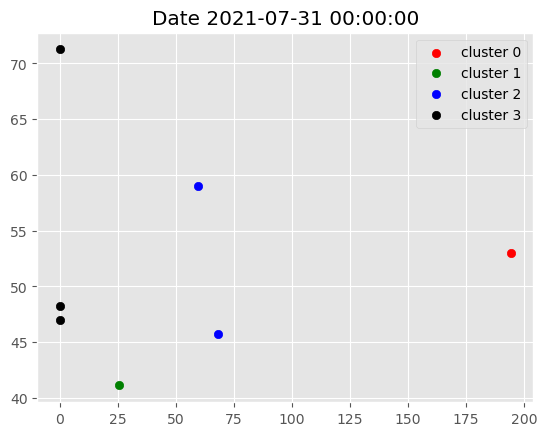

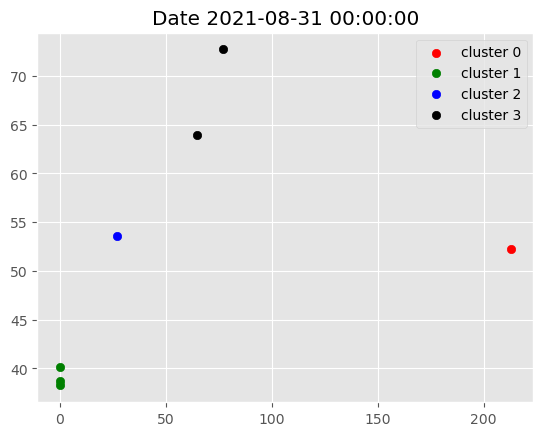

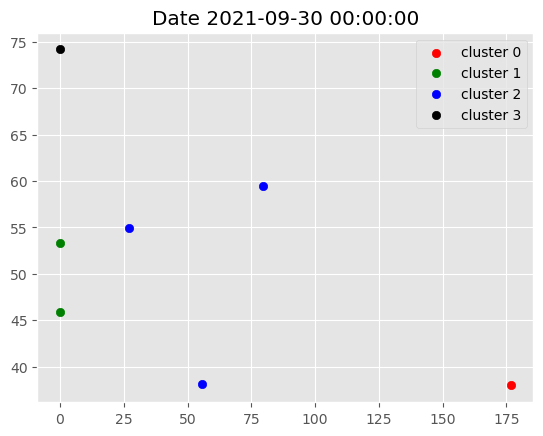

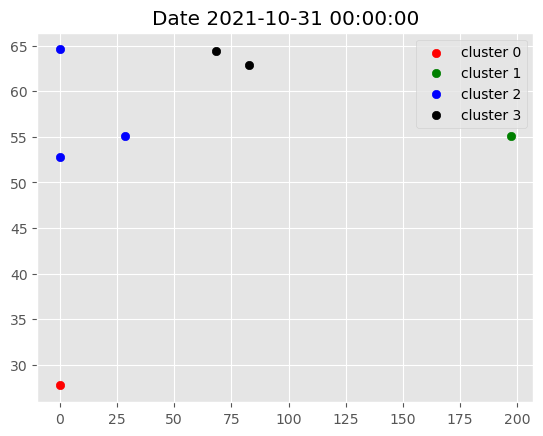

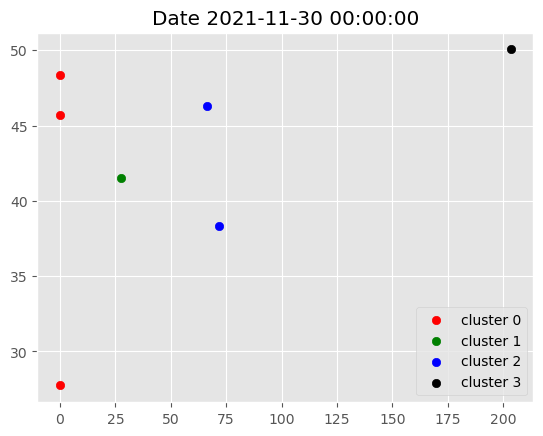

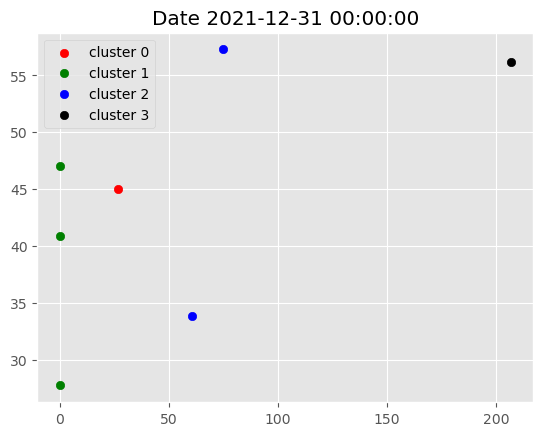

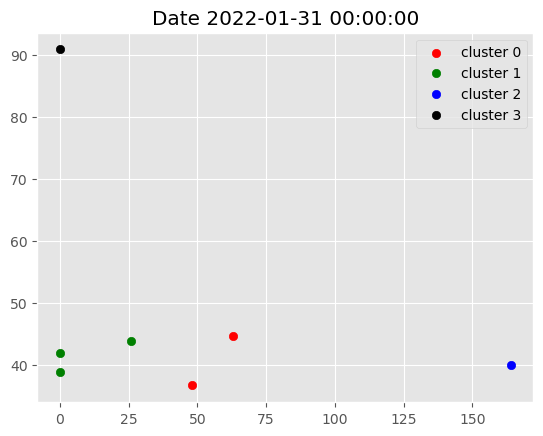

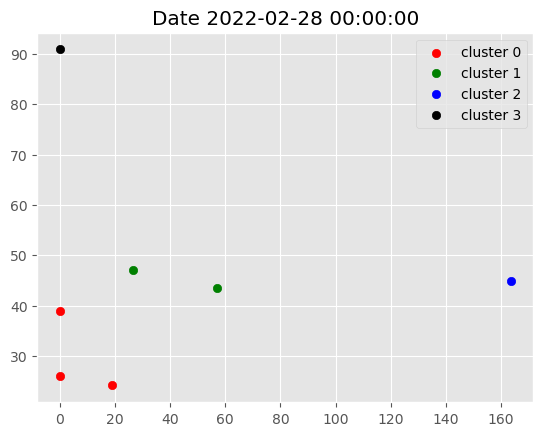

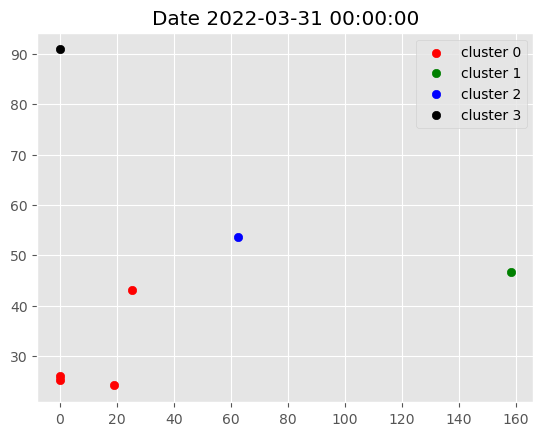

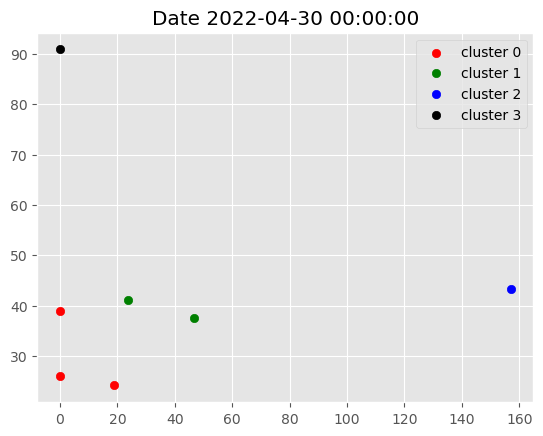

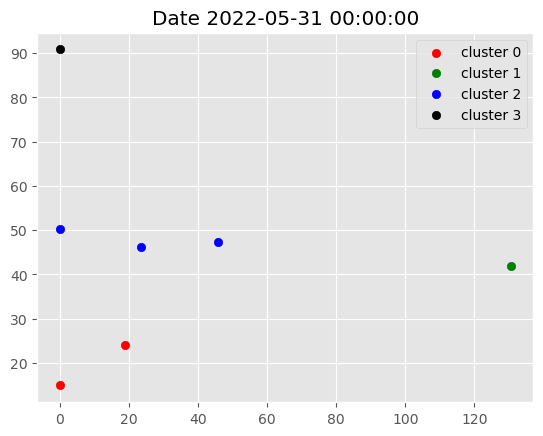

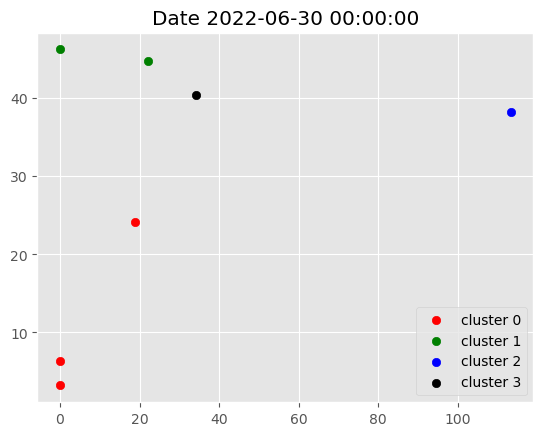

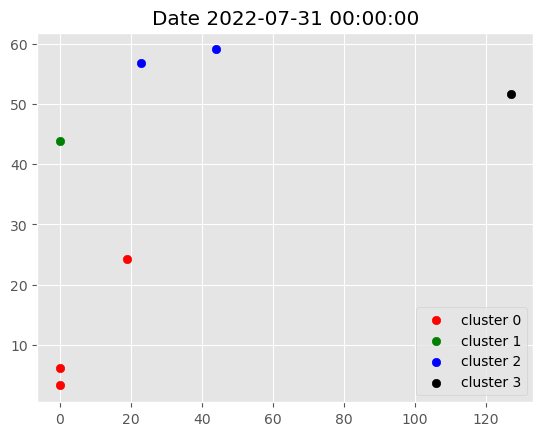

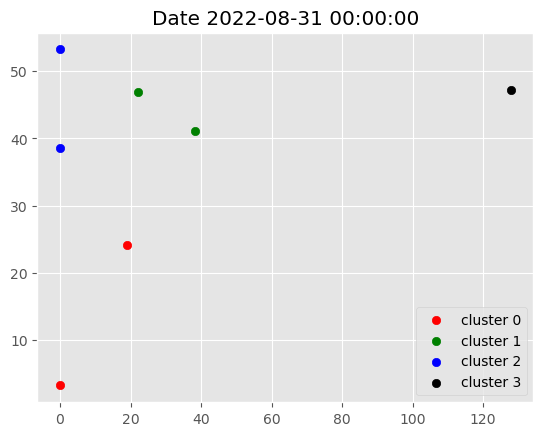

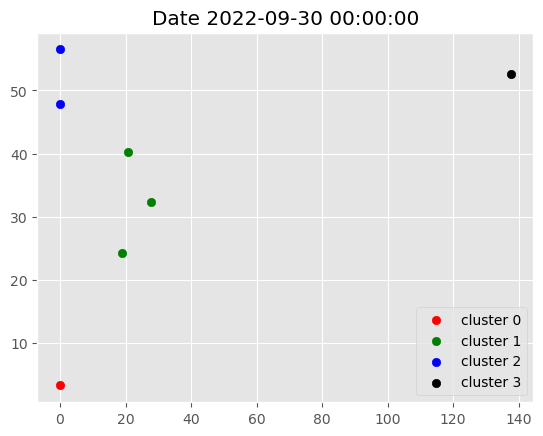

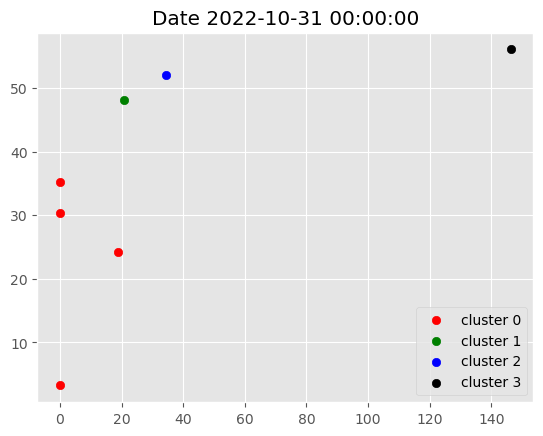

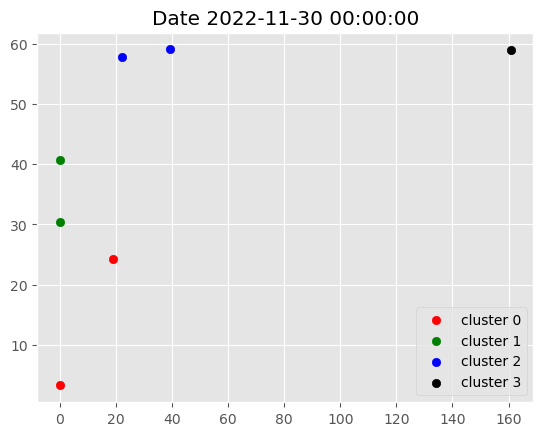

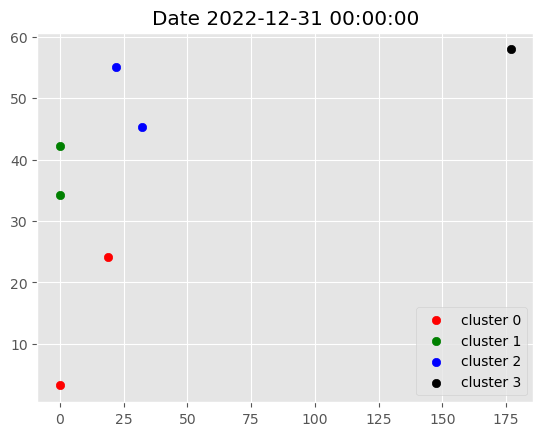

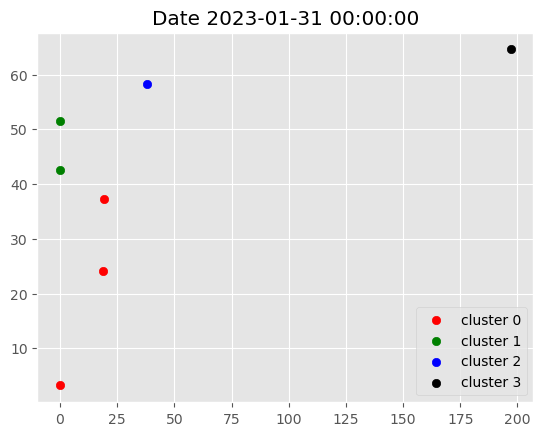

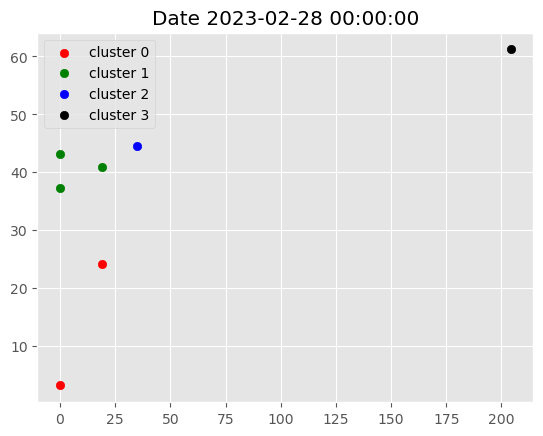

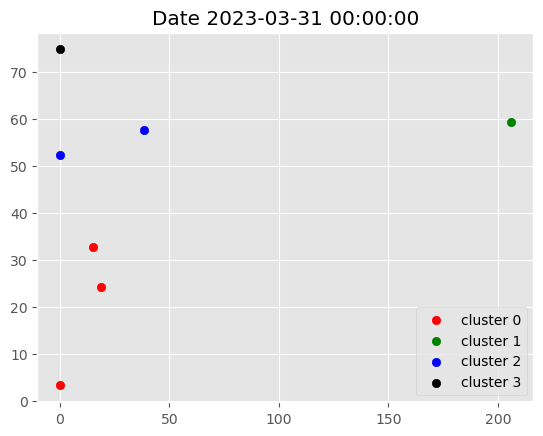

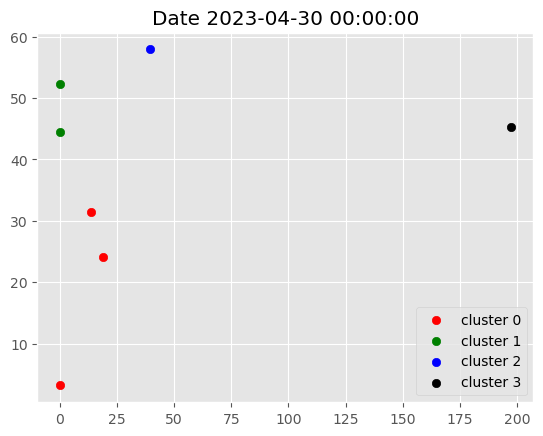

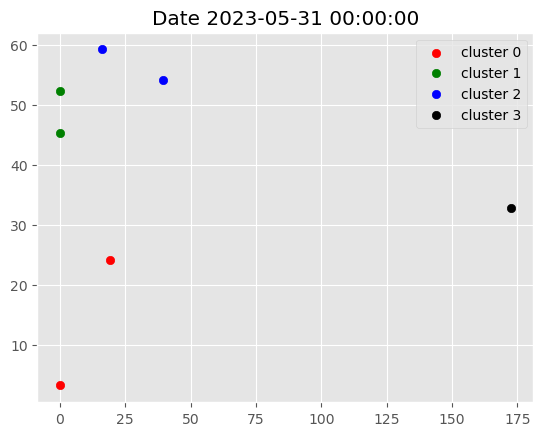

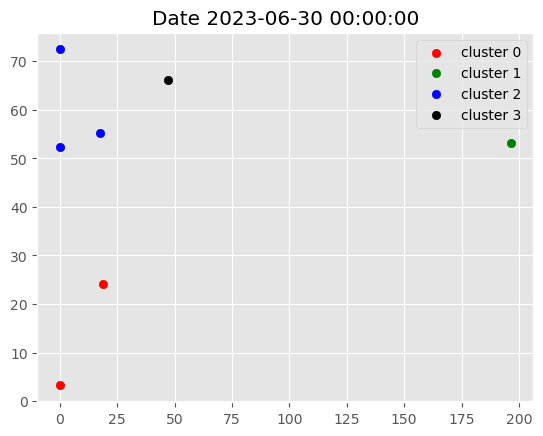

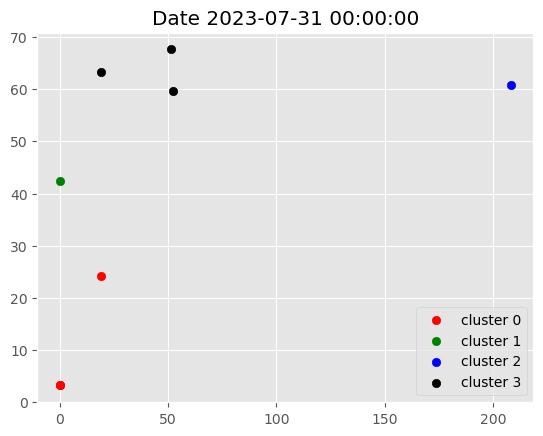

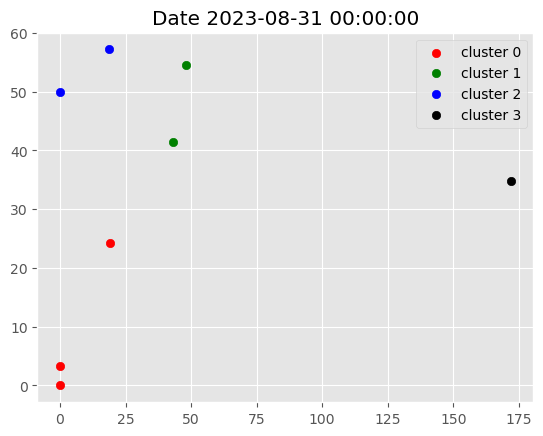

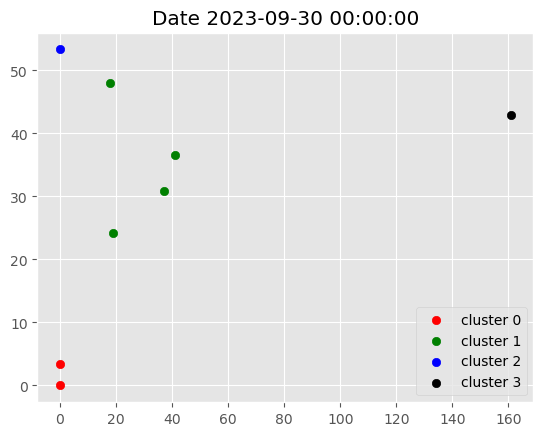

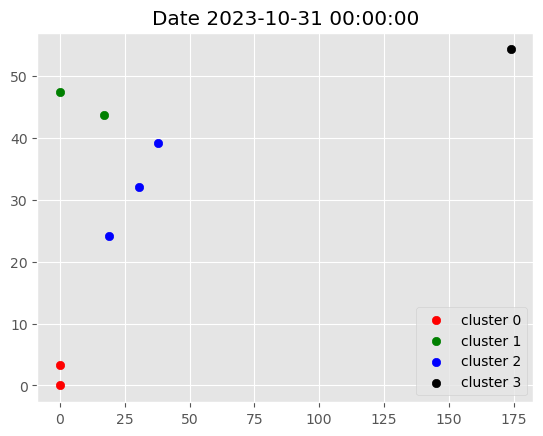

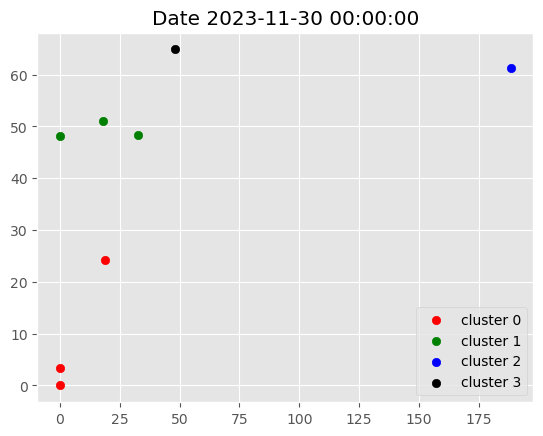

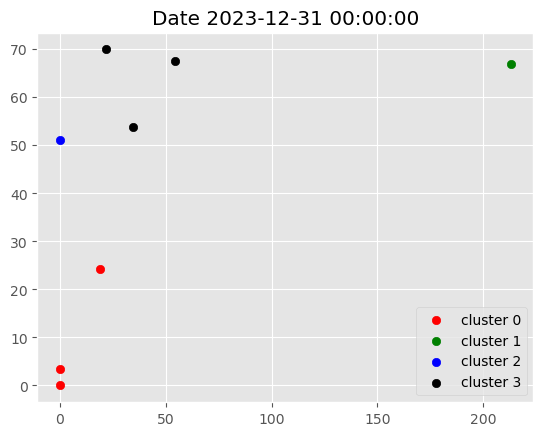

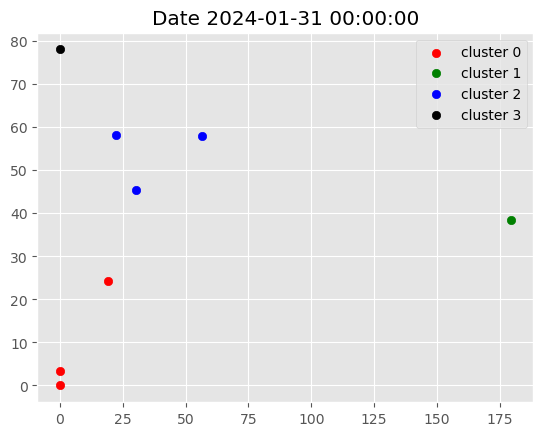

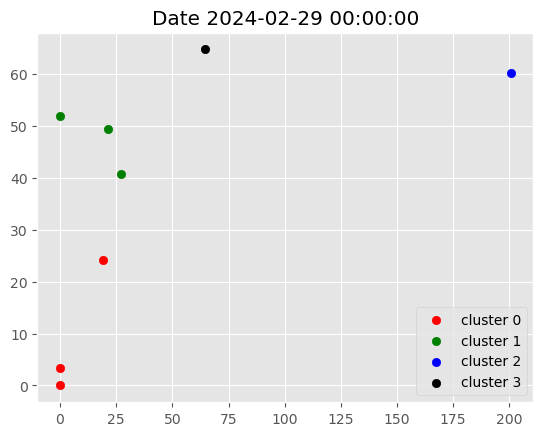

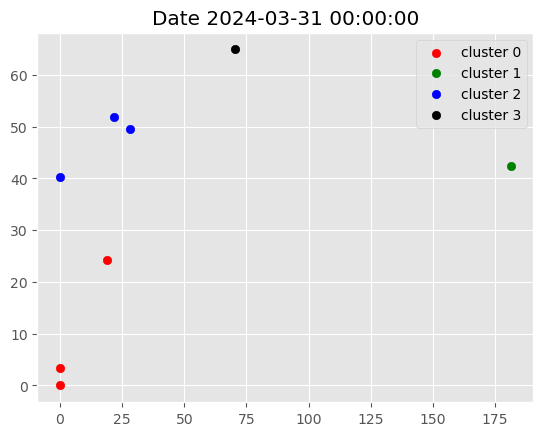

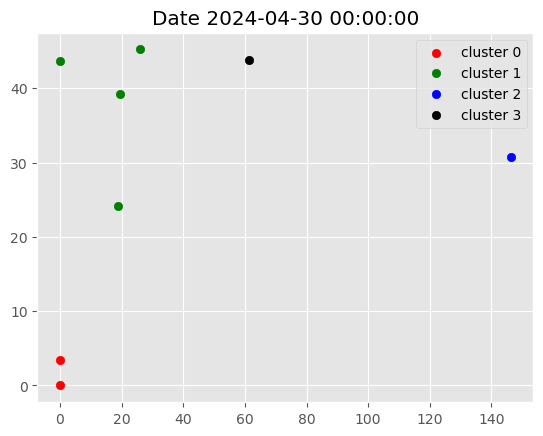

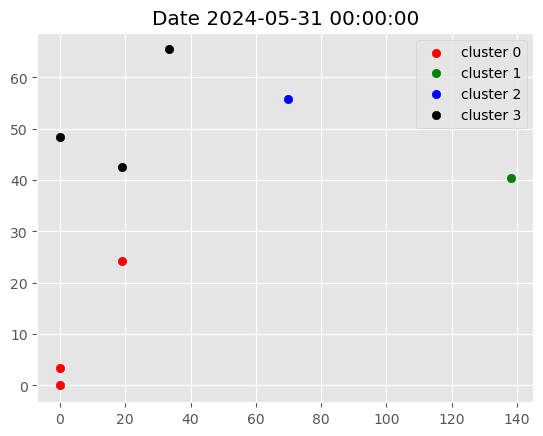

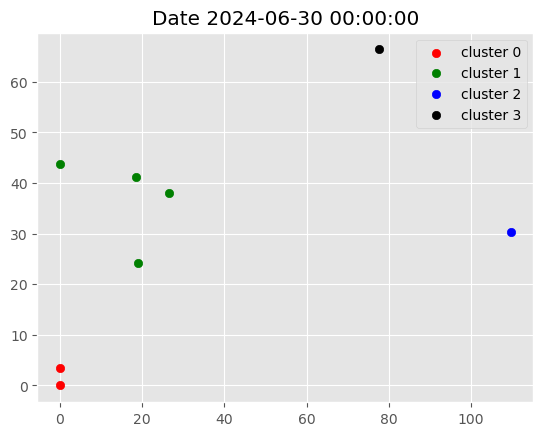

In [89]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    
    g = data.xs(i, level=0)
    
    plt.title(f'Date {i}')
    
    plot_clusters(g)

In [82]:
filtered_df = data[data['cluster']==3].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:
    
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()
    
fixed_dates

{'2021-08-01': ['YNDX'],
 '2021-09-01': ['UPRO'],
 '2021-10-01': ['SFIN'],
 '2021-11-01': ['UPRO'],
 '2021-12-01': ['UPRO'],
 '2022-01-01': ['YNDX'],
 '2022-02-01': ['UPRO', 'YNDX'],
 '2022-03-01': ['UPRO'],
 '2022-04-01': ['UPRO'],
 '2022-05-01': ['UPRO'],
 '2022-06-01': ['UPRO'],
 '2022-07-01': ['ALRS', 'ROSN'],
 '2022-08-01': ['ALRS'],
 '2022-09-01': ['ROSN', 'SFIN'],
 '2022-10-01': ['ROSN'],
 '2022-11-01': ['ALRS'],
 '2022-12-01': ['ALRS'],
 '2023-01-01': ['UPRO'],
 '2023-02-01': ['ROSN', 'SFIN'],
 '2023-03-01': ['ALRS'],
 '2023-04-01': ['UPRO'],
 '2023-05-01': ['ROSN', 'SFIN'],
 '2023-06-01': ['ALRS', 'ROSN', 'SFIN'],
 '2023-07-01': ['ALRS', 'ROSN', 'SFIN'],
 '2023-08-01': ['UPRO', 'HYDR'],
 '2023-09-01': ['ALRS', 'ROSN'],
 '2023-10-01': ['ALRS', 'ROSN'],
 '2023-11-01': ['ALRS', 'ROSN'],
 '2023-12-01': ['ALRS', 'ROSN', 'HYDR'],
 '2024-01-01': ['ALRS', 'ROSN', 'HYDR'],
 '2024-02-01': ['ALRS', 'ROSN'],
 '2024-03-01': ['ALRS', 'ROSN', 'HYDR'],
 '2024-04-01': ['ALRS', 'HYDR'],
 '2024-

In [90]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0):
    
    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=252)
    
    cov = risk_models.sample_cov(prices=prices,
                                 frequency=252)
    
    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .1),
                           solver='SCS')
    
    weights = ef.max_sharpe()
    
    return ef.clean_weights()


In [92]:
stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end=data.index.get_level_values('date').unique()[-1])

new_df

[*********************100%%**********************]  8 of 8 completed


Price       Adj Close                                                  \
Ticker           ALRS        FIVE       HYDR    MGNT     ROSN    SFIN   
Date                                                                    
2020-07-31  17.162849  108.910004        NaN  0.0150  0.08399  0.0185   
2020-08-03  17.277981  107.970001        NaN  0.0150  0.08399  0.0169   
2020-08-04  17.269125  108.029999        NaN  0.0150  0.08250  0.0169   
2020-08-05  17.269125  106.629997        NaN  0.0125  0.08250  0.0160   
2020-08-06  17.260269  102.849998        NaN  0.0100  0.08250  0.0285   
...               ...         ...        ...     ...      ...     ...   
2024-06-21  18.230000  115.339996  27.010000  0.0002  0.01660  0.0001   
2024-06-24  18.389999  116.290001  27.080000  0.0002  0.01690  0.0001   
2024-06-25  18.559999  110.500000  26.900000  0.0002  0.01680  0.0001   
2024-06-26  18.440001  109.669998  26.500000  0.0002  0.01440  0.0001   
2024-06-27  18.490000  109.230003  26.280001     NaN      NaN     NaN   

Price                                 Close              ...       Open  \
Ticker           UPRO       YNDX       ALRS        FIVE  ...       UPRO   
Date                                                     ...              
2020-07-31  25.618675  57.540001  19.379999  108.910004  ...  25.969999   
2020-08-03  26.138796  58.560001  19.510000  107.970001  ...  26.545000   
2020-08-04  26.433212  58.689999  19.500000  108.029999  ...  26.430000   
2020-08-05  26.933706  59.799999  19.500000  106.629997  ...  27.320000   
2020-08-06  27.483271  60.000000  19.490000  102.849998  ...  27.299999   
...               ...        ...        ...         ...  ...        ...   
2024-06-21  76.977692  18.940001  18.230000  115.339996  ...  77.349998   
2024-06-24  76.369446  18.940001  18.389999  116.290001  ...  77.279999   
2024-06-25  77.217003  18.940001  18.559999  110.500000  ...  77.120003   
2024-06-26  77.529999  18.940001  18.440001  109.669998  ...  76.730003   
2024-06-27  77.529999        NaN  18.490000  109.230003  ...  77.410004   

Price                  Volume                                                 \
Ticker           YNDX    ALRS     FIVE     HYDR     MGNT     ROSN       SFIN   
Date                                                                           
2020-07-31  57.389999   28500   639900      NaN      0.0  69000.0   276207.0   
2020-08-03  58.349998   28300   683200      NaN      0.0      0.0   257100.0   
2020-08-04  58.419998   17600   851200      NaN      0.0   3000.0   272100.0   
2020-08-05  59.419998   28400   910300      NaN  20000.0      0.0   881600.0   
2020-08-06  59.639999   16400   829100      NaN  10000.0   1000.0  4270913.0   
...               ...     ...      ...      ...      ...      ...        ...   
2024-06-21  18.940001   80600  1464600  84600.0      0.0      0.0        0.0   
2024-06-24  18.940001  101100  1177400  23100.0      0.0   6100.0        0.0   
2024-06-25  18.940001   25500  1081300  15900.0      0.0   5500.0        0.0   
2024-06-26  18.940001   45500  2067700  22800.0      0.0   2100.0        0.0   
2024-06-27        NaN    2354    66327    987.0      NaN      NaN        NaN   

Price                            
Ticker          UPRO       YNDX  
Date                             
2020-07-31  15709000  1894425.0  
2020-08-03   9230800  1641494.0  
2020-08-04  10125800  1201681.0  
2020-08-05   9164400  1508421.0  
2020-08-06  11800800  1653280.0  
...              ...        ...  
2024-06-21   3249100        0.0  
2024-06-24   3760400        0.0  
2024-06-25   2583900        0.0  
2024-06-26   2225200        0.0  
2024-06-27    587943        NaN  

[983 rows x 48 columns]

In [95]:
#returns_dataframe = np.log(new_df['Adj Close']).diff()

#portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():

    try:

        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')
        
        cols = fixed_dates[start_date]
    
        optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')
    
        optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')

        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]

        success = False
        try:
    
            weights = optimize_weights(prices=optimization_df, lower_bound=round(1/(len(optimization_df.columns)*2),3))
    
            weights = pd.DataFrame(weights, index=pd.Series(0))

            success = True
        except:
            print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights' )

        if success==False:
            weigths = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                    index=optimization_df.columns.tolist(),
                                    columns=pd.Series(0)).T
    
        temp_df = returns_dataframe[start_date:end_date]
    
        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
            .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                  left_index=True,
                  right_index=True)\
            .reset_index().set_index(['Date','Ticker']).unstack().stack()
    
        temp_df.index.names = ['names', 'ticker']
    
        temp_df['weighted_return'] = temp_df['return']*temp_df['weight']
    
        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')
    
        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)

    except Exception as e:

        print(e)

portfolio_df

Max Sharpe Optimization failed for 2021-08-01, Continuing with Equal-Weights
'return'
Max Sharpe Optimization failed for 2021-09-01, Continuing with Equal-Weights
'return'
Max Sharpe Optimization failed for 2021-10-01, Continuing with Equal-Weights
'return'
Max Sharpe Optimization failed for 2021-11-01, Continuing with Equal-Weights
'return'
Max Sharpe Optimization failed for 2021-12-01, Continuing with Equal-Weights
'return'
Max Sharpe Optimization failed for 2022-01-01, Continuing with Equal-Weights
'return'
Max Sharpe Optimization failed for 2022-02-01, Continuing with Equal-Weights
'return'
Max Sharpe Optimization failed for 2022-03-01, Continuing with Equal-Weights
'return'
Max Sharpe Optimization failed for 2022-04-01, Continuing with Equal-Weights
'return'
Max Sharpe Optimization failed for 2022-05-01, Continuing with Equal-Weights
'return'
Max Sharpe Optimization failed for 2022-06-01, Continuing with Equal-Weights
'return'
Max Sharpe Optimization failed for 2022-07-01, Continu

Empty DataFrame
Columns: []
Index: []

In [97]:
returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    
    try:

        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

        cols = fixed_dates[start_date]

        optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')

        optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        
        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]
        
        success = False
        try:
            weights = optimize_weights(prices=optimization_df,
                                   lower_bound=round(1/(len(optimization_df.columns)*2),3))

            weights = pd.DataFrame(weights, index=pd.Series(0))
            
            success = True
        except:
            print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights')
        
        if success==False:
            weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                     index=optimization_df.columns.tolist(),
                                     columns=pd.Series(0)).T
        
        temp_df = returns_dataframe[start_date:end_date]

        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
                   .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                          left_index=True,
                          right_index=True)\
                   .reset_index().set_index(['Date', 'index']).unstack().stack()

        temp_df.index.names = ['date', 'ticker']

        temp_df['weighted_return'] = temp_df['return']*temp_df['weight']

        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')

        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
    
    except Exception as e:
        print(e)

portfolio_df = portfolio_df.drop_duplicates()

portfolio_df

Max Sharpe Optimization failed for 2021-08-01, Continuing with Equal-Weights
"None of ['index'] are in the columns"
Max Sharpe Optimization failed for 2021-09-01, Continuing with Equal-Weights
"None of ['index'] are in the columns"
Max Sharpe Optimization failed for 2021-10-01, Continuing with Equal-Weights
"None of ['index'] are in the columns"
Max Sharpe Optimization failed for 2021-11-01, Continuing with Equal-Weights
"None of ['index'] are in the columns"
Max Sharpe Optimization failed for 2021-12-01, Continuing with Equal-Weights
"None of ['index'] are in the columns"
Max Sharpe Optimization failed for 2022-01-01, Continuing with Equal-Weights
"None of ['index'] are in the columns"
Max Sharpe Optimization failed for 2022-02-01, Continuing with Equal-Weights
"None of ['index'] are in the columns"
Max Sharpe Optimization failed for 2022-03-01, Continuing with Equal-Weights
"None of ['index'] are in the columns"
Max Sharpe Optimization failed for 2022-04-01, Continuing with Equal-Wei

Empty DataFrame
Columns: []
Index: []

In [98]:

portfolio_df

Empty DataFrame
Columns: []
Index: []

In [103]:
spy = yf.download(tickers='ALRS',
                  start='2015-01-01',
                  end=dt.date.today())

[*********************100%%**********************]  1 of 1 completed


In [104]:
spy

Open       High        Low      Close  Adj Close  Volume
Date                                                                     
2015-01-02  20.500000  20.500000  20.500000  20.500000  15.817534     500
2015-01-05  20.010000  20.010000  20.010000  20.010000  15.439459     400
2015-01-06  19.750000  19.750000  19.750000  19.750000  15.238840     300
2015-01-07  19.750000  19.750000  19.750000  19.750000  15.238840       0
2015-01-08  20.000000  20.000000  20.000000  20.000000  15.431741     100
...               ...        ...        ...        ...        ...     ...
2024-06-20  18.540001  18.639999  18.469999  18.530001  18.530001   36500
2024-06-21  18.590000  18.590000  18.209999  18.230000  18.230000   80600
2024-06-24  18.240000  18.580000  18.160000  18.389999  18.389999  101100
2024-06-25  18.330000  18.680000  18.330000  18.559999  18.559999   25500
2024-06-26  18.410000  18.719999  18.410000  18.440001  18.440001   45500

[2386 rows x 6 columns]